## 1. Desafio ClickBus - Data Science:

### 1.1 Descrição:
A ClickBus quer ajudar as viações a entender como o desconto dado por elas contribuiu para o aumento nas vendas, bem como solicitar descontos assertivos para o próximo feriado.

### 1.2 Como são feitas as vendas: 
As viações definem o preço do ticket e este é cobrado do cliente final. Parte desse valor cobrado fica com a ClickBus (comissão) e outra parte é devolvido para a empresa de ônibus. A ClickBus provê soluções de inteligência que diz para as viações qual é o preço a ser cobrado na viagem, mas após o período de descontos dados as viações pedem análises do retorno destes.

### 1.3 O que deverá ser entregue:
Algumas perguntas deverão ser respondidas:

- Qual o volume de descontos dado por viação? E por mês?
- Os descontos mais utilizados (ou seja, os tickets com desconto mais vendidos) têm alguma relação com o fato de serem e-tickets ? E tem relação com a disposição do assento entre janela/corredor?
- Há alguma relação entre variação de preço na rota e variação de vendas na mesma acima do "normal"?
- Pensando no crescimento de vendas através do desconto, para quais viações você pediria descontos no final de ano e em quais rotas?

### 1.4 Dados:
O arquivo tickets_dataset.csv contém uma lista de tickets vendidos pela ClickBus. Cada linha representa um ticket e tem suas principais informações.

A descrição de cada coluna está abaixo:
- datetime_booking: Dia e hora que o ticket foi vendido<br>
- kiosk_printed_flag: Flag se o ticket foi impresso em um dos quiosques ClickBus<br>
- eticket_flag: Flag se o ticket é do modelo e-ticket (que não necessita ser impresso)<br>
- dd_seat_number: Número do assento<br>
- travel_company: Viação (ou empresa de ônibus)<br>
- travel_company_commission: % de comissão que a ClickBus cobrou da Viação nesse ticket<br>
- route: Rota (ou viagem, conjunto de origem e destino)<br>
- unit_ticket_price_success: Preço do ticket<br>
- service_class_id: ID do tipo (classe) do assento

### 1.5 Dicas:
Para calcular o desconto, obtenha primeiro o valor inteiro do ticket. Ele pode ser obtido calculando o valor de ticket mais comum por mês, rota, viação e classe de serviço. O que estiver abaixo de 80% desse valor inteiro é um ticket com desconto.

Considere os assentos ímpares como lugares na janela e os pares como lugares no corredor dos ônibus.

### 2. Import dos dados e bibliotecas:

In [0]:
import pandas as pd
import numpy as np
import scipy.stats.mstats as mstats
from unicodedata import normalize

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [0]:
# Leitura do arquivo:
url = 'https://s3-sa-east-1.amazonaws.com/static2.clickbus.com.br/data-science/case-desconto/tickets_dataset.csv'
df = pd.read_csv(url)

In [0]:
# Removendo coluna com Index:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [0]:
# Formato do dataset:
print('Número de linhas:', df.shape[0])
print('Número de colunas:', df.shape[1])

Número de linhas: 4341329
Número de colunas: 9


In [0]:
# Leitura das primeiras linhas:
df.head()

,datetime_booking,kiosk_printed_flag,eticket_flag,dd_seat_number,travel_company,travel_company_commission,route,unit_ticket_price_success,service_class_id
0,2019-01-01 18:06:00,0,0,38,Deusa Assento,0.000,Igrapiuna | Echapora,98.345,0
1,2019-01-01 13:36:00,0,0,15,Estrada Papa Carinho,0.180,Igrapiuna | Governador Nunes Freire,52.325,1
2,2019-01-01 19:17:00,0,0,27,Real Boa Assento,0.000,Igrapiuna | Carbonita,26.390,0
3,2019-01-01 12:07:00,0,0,28,Deusa Santa LTDA,0.126,Igrapiuna | Cristiano Otoni,33.995,0
4,2019-01-01 18:17:00,0,0,17,Deusa Santa LTDA,0.126,Igrapiuna | Paranaita,34.970,0


In [0]:
# Verificando o tipo dos dados de cada coluna:
df.dtypes

datetime_booking              object
kiosk_printed_flag             int64
eticket_flag                   int64
dd_seat_number                 int64
travel_company                object
travel_company_commission    float64
route                         object
unit_ticket_price_success    float64
service_class_id               int64
dtype: object

In [0]:
# Convertendo o tipo da coluna 'datetime_booking':
df['datetime_booking'] = pd.to_datetime(df['datetime_booking'])

### 3. Análise Exploratória:

In [0]:
# Verificando valores nulos:
print('Total de nulos do dataset:', df.isnull().sum().sum())

Total de nulos do dataset: 0


#### 3.1. datetime_booking (Dia e hora que o ticket foi vendido):

In [0]:
# Range de datas do dataset:
print('Primeiro registro:', df['datetime_booking'].min())
print('Último registro:', df['datetime_booking'].max())

Primeiro registro: 2019-01-01 00:00:22
Último registro: 2019-11-04 23:59:15


In [0]:
# Criando colunas para dia, mês e dia da semana:
df['day'] = df['datetime_booking'].dt.day
df['month'] = df['datetime_booking'].dt.month
df['weekday'] = df['datetime_booking'].dt.weekday

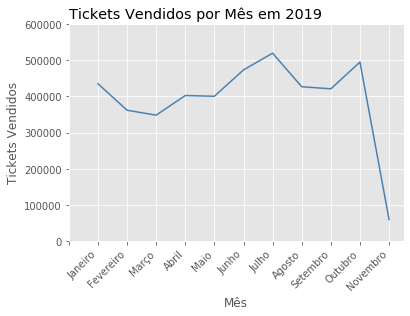

In [0]:
# Analisando as vendas por mês em 2019:
tickets_mes = pd.DataFrame(df.groupby('month')['datetime_booking'].count())
meses = [' ', 'Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho', 'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro']
plt.plot(tickets_mes, color='steelblue')
plt.xlabel('Mês')
plt.ylabel('Tickets Vendidos')
plt.xticks(np.arange(0, 12, 1), meses, rotation=45, horizontalalignment='right')
plt.yticks(np.arange(0, 700000, 100000))
plt.title('Tickets Vendidos por Mês em 2019', loc='left');

Percebe-se o mês de Julho apresentou o maior volume de vendas, seguido de Outubro e Junho.

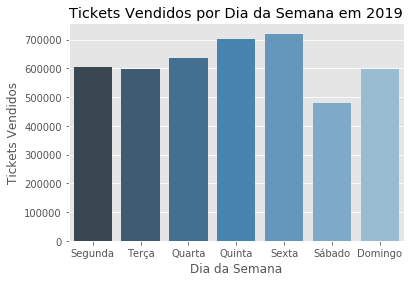

In [0]:
# Analisando as vendas conforme o dia da semana:
dias_semana = ['Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta', 'Sábado', 'Domingo']
sns.countplot(data=df, x='weekday', palette='Blues_d')
plt.xlabel('Dia da Semana')
plt.ylabel('Tickets Vendidos')
plt.xticks(np.arange(0,7), dias_semana)
plt.title('Tickets Vendidos por Dia da Semana em 2019');

Percebe-se que o volume de vendas tende a ser maior nas sextas e quintas-feiras.

#### 3.2. travel_company_commission (% de comissão que a ClickBus cobrou da Viação nesse ticket):

In [0]:
# Analisando os diferentes percentuais de comissões que a ClickBus cobra:
comissions = pd.DataFrame(df['travel_company_commission'].unique())
comissions.columns = ['Comissão']
comissions

,Comissão
0,0.0000
1,0.1800
2,0.1260
3,0.1440
4,0.0846
5,0.0810
6,0.1980


Analisando a tabela, percebemos que a ClickBus cobra 7 diferentes percentuais de comissão sobre o valor do ticket das viações.

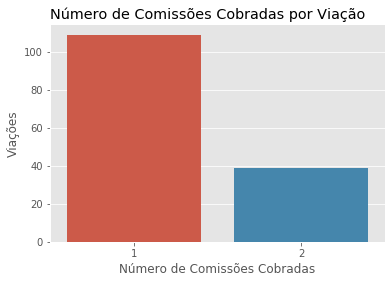

In [0]:
# Gerando um countplot do número de comissões que a ClickBus cobra por viação:
comissions_by_company = pd.DataFrame(df.groupby('travel_company')['travel_company_commission'].nunique())
sns.countplot(data = comissions_by_company, x='travel_company_commission')
plt.xlabel('Número de Comissões Cobradas')
plt.ylabel('Viações')
plt.title('Número de Comissões Cobradas por Viação', loc='left');

In [0]:
print('Número de empresas que a ClickBus cobra 1 taxa de comissão:', len(comissions_by_company[comissions_by_company['travel_company_commission'] == 1]))
print('Número de empresas que a ClickBus cobra 2 taxas de comissão:', len(comissions_by_company[comissions_by_company['travel_company_commission'] == 2]))

Número de empresas que a ClickBus cobra 1 taxa de comissão: 109
Número de empresas que a ClickBus cobra 2 taxas de comissão: 39


Para a maior parte das empresas (73,6%), a ClickBus cobra somente uma única taxa de comissão sobre o valor do ticket.

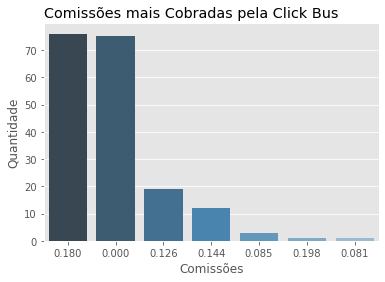

In [0]:
# Gerando um countplot das comissões:
comissions_by_company = pd.DataFrame(df.groupby(['travel_company', 'travel_company_commission']).first()).reset_index()[['travel_company', 'travel_company_commission']]
sns.countplot(data = comissions_by_company, x='travel_company_commission', order = comissions_by_company['travel_company_commission'].value_counts().index, palette='Blues_d')
plt.xlabel('Comissões')
plt.ylabel('Quantidade')
plt.title('Comissões mais Cobradas pela Click Bus', loc='left')
plt.xticks(np.arange(0,7), ['0.180', '0.000', '0.126', '0.144', '0.085', '0.198', '0.081']);

A taxa de comissão mais cobrada pela ClickBus é 18% (76 ocorrências), seguida de 0% (75 ocorrências).

#### 3.3. unit_ticket_price_success (Preço do ticket):

In [0]:
# Analisando as principais características da coluna 'unit_ticket_price_success':
pd.DataFrame(df['unit_ticket_price_success'].describe())

,unit_ticket_price_success
count,4.341329e+06
mean,1.146509e+02
std,8.095446e+01
min,0.000000e+00
25%,5.579600e+01
50%,9.386000e+01
75%,1.522300e+02
max,1.268930e+03


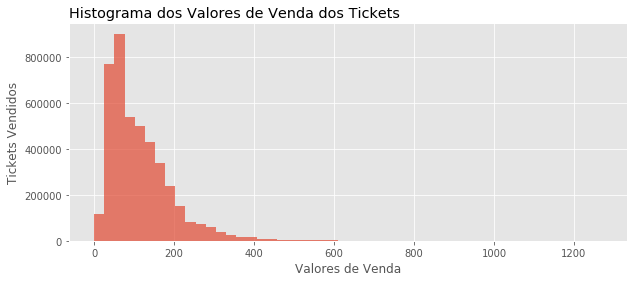

In [0]:
# Gerando um histograma dos preços de venda dos tickets:
plt.figure(figsize=(10,4))
sns.distplot(df['unit_ticket_price_success'], hist=True, kde=False, hist_kws=dict(alpha=0.7))
plt.title('Histograma dos Valores de Venda dos Tickets', loc='left')
plt.xlabel('Valores de Venda')
plt.ylabel('Tickets Vendidos');

Os resultados mostram que a variável 'unit_ticket_price_success' possui outliers, pois o valor máximo (1268.93) é muito mais alto do que os valores do 3° quartil (75% dos dados), ainda que os valores de média e mediana (50%) são próximos.

#### 3.4. dd_seat_number (Número do assento):

In [0]:
# Adicionando uma coluna com valores binários para assentos no corredor (0) ou janela (1):
df['seat_position'] = list(map(lambda x: 0 if x%2 == 0 else 1, df['dd_seat_number']))

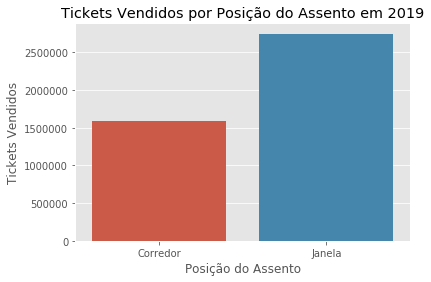

In [0]:
# Gerando um countplot dos Tickets Vendidos por Posição do Assento:
sns.countplot(data=df, x='seat_position')
plt.xlabel('Posição do Assento')
plt.ylabel('Tickets Vendidos')
plt.xticks(np.arange(0,2), ['Corredor', 'Janela'])
plt.title('Tickets Vendidos por Posição do Assento em 2019');

In [0]:
print('Percentual de tickets vendidos no corredor (0):', round((len(df[df['seat_position']==0])/len(df)*100), 2), '%')
print('Percentual de tickets vendidos na janela (1):', round((len(df[df['seat_position']==1])/len(df)*100), 2), '%')

Percentual de tickets vendidos no corredor (0): 36.7 %
Percentual de tickets vendidos na janela (1): 63.3 %


#### 3.5. kiosk_printed_flag (Flag se o ticket foi impresso em um dos quiosques ClickBus):

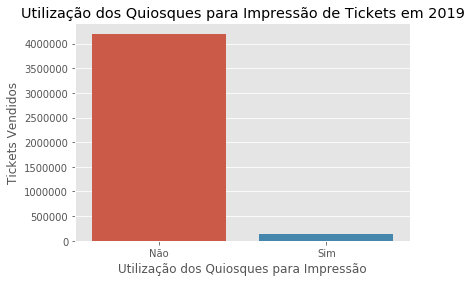

In [0]:
# Gerando um countplot da impressão de tickets nos quiosques:
sns.countplot(data=df, x='kiosk_printed_flag')
plt.ylabel('Tickets Vendidos')
plt.xlabel('Utilização dos Quiosques para Impressão')
plt.xticks(np.arange(0,2), ['Não', 'Sim'])
plt.title('Utilização dos Quiosques para Impressão de Tickets em 2019');

In [0]:
print('Percentual de tickets não impressos no quiosque:', round((len(df[df['kiosk_printed_flag']==0])/len(df)*100), 2), '%')
print('Percentual de tickets impressos no quiosque:', round((len(df[df['kiosk_printed_flag']==1])/len(df)*100), 2), '%')

Percentual de tickets não impressos no quiosque: 96.72 %
Percentual de tickets impressos no quiosque: 3.28 %


#### 3.6. eticket_flag (Flag se o ticket é do modelo e-ticket, logo não necessita ser impresso):

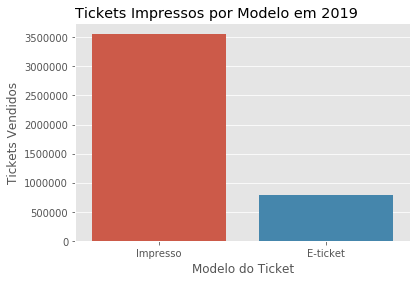

In [0]:
# Gerando um countplot do modelo do ticket:
sns.countplot(data=df, x='eticket_flag')
plt.ylabel('Tickets Vendidos')
plt.xlabel('Modelo do Ticket')
plt.xticks(np.arange(0,2), ['Impresso', 'E-ticket'])
plt.title('Tickets Impressos por Modelo em 2019', loc='left');

In [0]:
print('Percentual de não e-tickets (0):', round((len(df[df['eticket_flag']==0])/len(df)*100), 2), '%')
print('Percentual de e-tickets (1):', round((len(df[df['eticket_flag']==1])/len(df)*100), 2), '%')

Percentual de não e-tickets (0): 82.03 %
Percentual de e-tickets (1): 17.97 %


#### 3.7. travel_company (Viação/empresa de ônibus):

In [0]:
print('Número de viações distintas:', df['travel_company'].nunique())

Número de viações distintas: 148


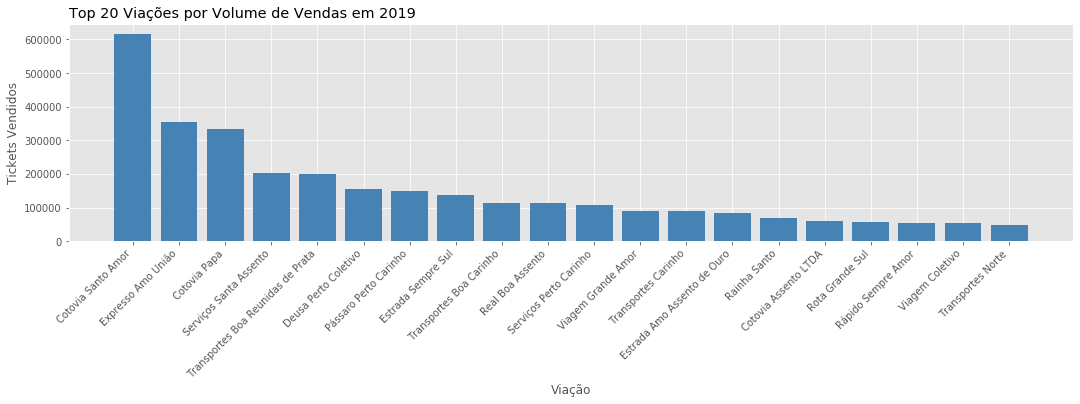

In [0]:
# Gerando um gráfico de barras das top 20 viações por volume de vendas:
plt.figure(figsize=(18, 4))
top_viacoes = pd.DataFrame(df.groupby('travel_company')['datetime_booking'].count()).sort_values('datetime_booking', ascending=False).head(20)
plt.bar(top_viacoes.index, top_viacoes['datetime_booking'], color='steelblue')
plt.xticks(rotation=45, horizontalalignment='right')
plt.ylabel('Tickets Vendidos')
plt.xlabel('Viação')
plt.title('Top 20 Viações por Volume de Vendas em 2019', loc='left');

In [0]:
print('Top 20 viações representam', round(sum(top_viacoes['datetime_booking'])/len(df)*100, 2),'% do volume de vendas.')

#### 3.8. service_class_id (ID do tipo (classe) do assento):

In [0]:
print('Número de classes de serviço distintas:', df['service_class_id'].nunique())

Número de classes de serviço distintas: 41


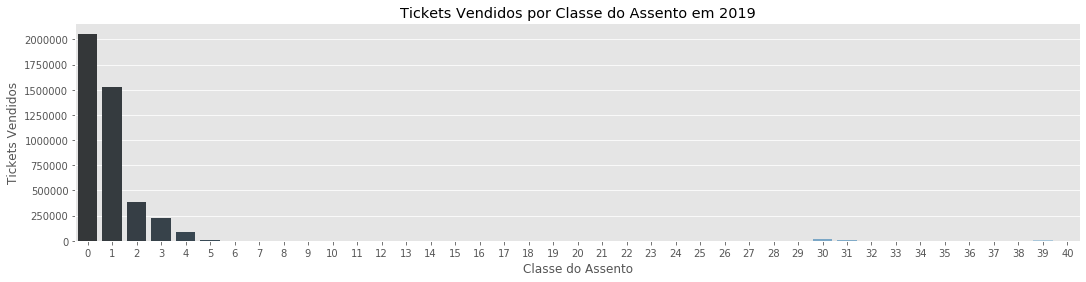

In [0]:
# Gerando um gráfico de barras das classes de assento mais vendidas em 2019:
plt.figure(figsize=(18,4))
sns.countplot(data=df, x='service_class_id',palette='GnBu_d')
plt.ylabel('Tickets Vendidos')
plt.xlabel('Classe do Assento')
plt.title('Tickets Vendidos por Classe do Assento em 2019');

#### 3.9. route (Rota ou viagem/conjunto de origem e destino):

In [0]:
print('Número de rotas distintas:', df['route'].nunique())

Número de rotas distintas: 25418


In [0]:
# Separando a coluna 'route' em 'city_origin' e 'city_destination':
df['city_origin'] = df['route'].map(lambda x: x.split('|')[0].rstrip())
df['city_destination'] = df['route'].map(lambda x: x.split('|')[1].rstrip())

In [0]:
# Analisando o número de cidades distintas:
print('Número de cidades de origem distintas:', df['city_origin'].nunique())
print('Número de cidades de destino distintas:', df['city_destination'].nunique())

Número de cidades de origem distintas: 31
Número de cidades de destino distintas: 835


### 4. Perguntas a Serem Respondidas:

#### 4.1 Qual o volume de descontos dado por viação? E por mês? 

In [0]:
# Para responder a esta pergunta, precisamos, primeiramente, definir o Preço Padrão dos Tickets através da Moda. Para isso, vamos agrupar os dados por mês, rota, viação e classe de serviço.
# Criando um dicionário com os valores de tickets mais frequentes agrupados por mês, rota, viação e classe de serviço:
dict_mode = df.groupby(['route', 'travel_company', 'service_class_id', 'month'])['unit_ticket_price_success'].agg(pd.Series.mode).to_dict()

In [0]:
# Criando uma coluna ('ticket_price_mode') com os valores da moda de cada agrupamento:
info = df[['route', 'travel_company', 'service_class_id', 'month']].apply(tuple, axis=1)
df['ticket_price_mode'] = list(map(lambda x: dict_mode[x], info))

In [0]:
# Calculando a média das modas onde possuimos mais de uma moda para o preço do ticket:
import numpy
df['ticket_price_mode'] = df['ticket_price_mode'].map(lambda x: x.mean() if type(x) == numpy.ndarray else x)

In [0]:
# Comparando o preço original ('unit_ticket_price_success') com o valor da moda ('ticket_price_mode') e inserindo uma nova coluna ('ticket_sale') que identifica se o ticket é promocional (1) ou não (0).
df['ticket_sale'] = np.where(df['unit_ticket_price_success'] <= 0.8*(df['ticket_price_mode']), 1, 0)

In [0]:
# Leitura das primeiras linhas do dataset:
df.head()

,datetime_booking,kiosk_printed_flag,eticket_flag,dd_seat_number,travel_company,travel_company_commission,route,unit_ticket_price_success,service_class_id,day,month,weekday,seat_position,city_origin,city_destination,ticket_price_mode,ticket_sale
0,2019-01-01 18:06:00,0,0,38,Deusa Assento,0.000,Igrapiuna | Echapora,98.345,0,1,1,1,0,Igrapiuna,Echapora,98.345,0
1,2019-01-01 13:36:00,0,0,15,Estrada Papa Carinho,0.180,Igrapiuna | Governador Nunes Freire,52.325,1,1,1,1,1,Igrapiuna,Governador Nunes Freire,52.325,0
2,2019-01-01 19:17:00,0,0,27,Real Boa Assento,0.000,Igrapiuna | Carbonita,26.390,0,1,1,1,1,Igrapiuna,Carbonita,26.390,0
3,2019-01-01 12:07:00,0,0,28,Deusa Santa LTDA,0.126,Igrapiuna | Cristiano Otoni,33.995,0,1,1,1,0,Igrapiuna,Cristiano Otoni,33.995,0
4,2019-01-01 18:17:00,0,0,17,Deusa Santa LTDA,0.126,Igrapiuna | Paranaita,34.970,0,1,1,1,1,Igrapiuna,Paranaita,34.970,0


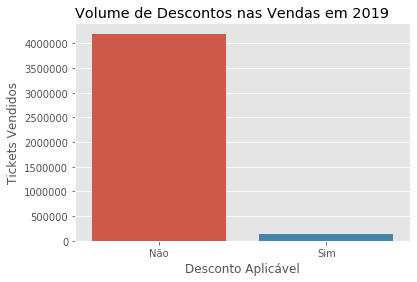

In [0]:
# Gerando um countplot da proporção entre tickets vendidos com e sem desconto:
sns.countplot(data=df, x='ticket_sale')
plt.title('Volume de Descontos nas Vendas em 2019', loc='left')
plt.xlabel('Desconto Aplicável')
plt.ylabel('Tickets Vendidos')
plt.xticks(np.arange(0,2), ['Não', 'Sim']);

In [0]:
print('Percentual de Vendas sem Desconto:', round((len(df[df['ticket_sale']==0])/len(df)*100), 2), '%')
print('Percentual de Vendas com Desconto:', round((len(df[df['ticket_sale']==1])/len(df)*100), 2), '%')

Percentual de Vendas sem Desconto: 96.69 %
Percentual de Vendas com Desconto: 3.31 %


In [0]:
# Agrupando os dados por viação, mês, comissão, promoção (0: não, 1:sim) e calculando a quantidade de tickets vendidos:
quant_sales_by_company = pd.DataFrame(df.groupby(['travel_company', 'month', 'travel_company_commission', 'ticket_sale'])['datetime_booking'].count()).reset_index()

In [0]:
# Alterando o formato do dataset:
quant_sales_by_company = quant_sales_by_company.pivot_table(index=['travel_company','month', 'travel_company_commission'], columns='ticket_sale', values='datetime_booking').reset_index()

In [0]:
# Alterando a nomenclatura das colunas, criando a coluna 'Tickets com Desconto (%)' e preenchendo os valores nulos com zero:
quant_sales_by_company.columns = ['travel_company', 'month', 'travel_company_commission', 'no_sale', 'sale']
quant_sales_by_company['Tickets Com Desconto (%)'] = (quant_sales_by_company['sale']/(sum(quant_sales_by_company['no_sale'], quant_sales_by_company['sale'])))*100
quant_sales_by_company = quant_sales_by_company.fillna(0)

In [0]:
# Agrupando os dados por viação, mês, promoção (0: não, 1:sim) e calculando o total de vendas (em R$):
vol_sales_by_company = pd.DataFrame(df.groupby(['travel_company', 'month', 'ticket_sale'])['unit_ticket_price_success'].sum()).reset_index()
vol_sales_by_company = vol_sales_by_company.pivot_table(index=['travel_company','month'], columns='ticket_sale', values='unit_ticket_price_success').reset_index().fillna(0)
vol_sales_by_company.columns = ['travel_company','month', 'no_sale_price', 'sale_price']

In [0]:
# Concatenando as colunas dos datasets:
sales_by_company = pd.concat([quant_sales_by_company, vol_sales_by_company[['no_sale_price', 'sale_price']]], axis=1)

In [0]:
# Alterando a nomenclatura das colunas:
sales_by_company.columns = ['Viação', 'Mês', 'Comissão', 'Tickets Sem Desconto', 'Tickets Com Desconto', 'Tickets Com Desconto (%)', 'Vendas Sem Desconto (R$)', 'Vendas Com Desconto (R$)']

In [0]:
# Exibindo as primeiras linhas do dataset:
sales_by_company.head(10)

,Viação,Mês,Comissão,Tickets Sem Desconto,Tickets Com Desconto,Tickets Com Desconto (%),Vendas Sem Desconto (R$),Vendas Com Desconto (R$)
0,Cotovia Amo Coletivo,1,0.18,106.0,0.0,0.000000,42125.824,0.0
1,Cotovia Amo Coletivo,2,0.18,83.0,0.0,0.000000,35461.868,0.0
2,Cotovia Amo Coletivo,3,0.18,69.0,0.0,0.000000,28188.641,0.0
3,Cotovia Amo Coletivo,4,0.18,43.0,0.0,0.000000,18062.863,0.0
4,Cotovia Amo Coletivo,5,0.18,37.0,0.0,0.000000,15657.941,0.0
5,Cotovia Amo Coletivo,6,0.18,76.0,0.0,0.000000,28791.308,0.0
6,Cotovia Amo Coletivo,7,0.18,94.0,0.0,0.000000,34751.158,0.0
7,Cotovia Amo Coletivo,8,0.18,58.0,1.0,0.000024,25493.806,520.0
8,Cotovia Amo Coletivo,9,0.18,49.0,0.0,0.000000,18297.474,0.0
9,Cotovia Amo Coletivo,10,0.18,52.0,0.0,0.000000,22654.021,0.0


##### Volume de descontos por viação:

In [0]:
# Agrupando os dados por viação e calculando o número de tickets vendidos com desconto:
vol_sales_by_company = pd.DataFrame(sales_by_company.groupby(['Viação'])['Tickets Com Desconto'].sum())

In [0]:
# Agrupando os dados por viação e calculando o número de tickets vendidos sem desconto:
vol_no_sales_by_company = pd.DataFrame(sales_by_company.groupby(['Viação'])['Tickets Sem Desconto'].sum())

In [0]:
vol_sales_by_company = pd.concat([vol_sales_by_company, vol_no_sales_by_company['Tickets Sem Desconto']], axis=1)

In [0]:
vol_sales_by_company['Tickets Com Desconto (%)'] = (vol_sales_by_company['Tickets Com Desconto']/(vol_sales_by_company['Tickets Sem Desconto'] + vol_sales_by_company['Tickets Com Desconto']))*100

In [0]:
# Ordenando o dataset por ordem decrescente de vendas com desconto:
vol_sales_by_company = vol_sales_by_company.sort_values('Tickets Com Desconto', ascending=False).reset_index()

In [0]:
vol_sales_by_company[:10]

,Viação,Tickets Com Desconto,Tickets Sem Desconto,Tickets Com Desconto (%)
0,Cotovia Santo Amor,21230.0,594635.0,3.447184
1,Serviços Santa Assento,19361.0,183028.0,9.566231
2,Expresso Amo União,16662.0,337792.0,4.700751
3,Cotovia Papa,16020.0,317493.0,4.803411
4,Estrada Sempre Sul,14532.0,124211.0,10.474042
5,Deusa Perto Coletivo,8884.0,144941.0,5.775394
6,Serviços Perto Carinho,8235.0,100396.0,7.580709
7,Viagem Grande Amor,6428.0,83593.0,7.140556
8,Estrada Amo Assento de Ouro,3970.0,79317.0,4.766650
9,Viagem Coletivo,3058.0,49744.0,5.791447


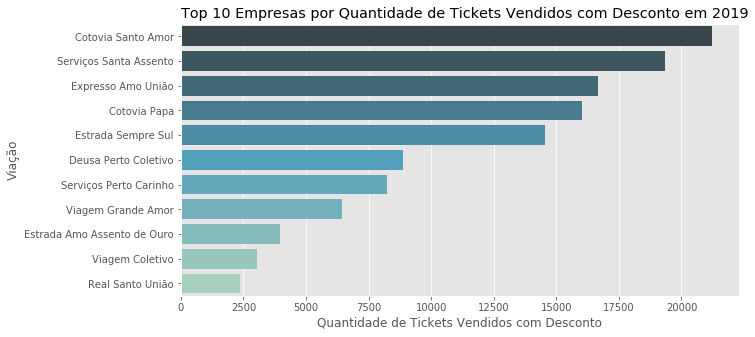

In [0]:
# Gerando um gráfico de barras das empresas com maior volume de vendas de tickets com desconto:
plt.subplots(figsize=(10,5))
sns.barplot(x ='Tickets Com Desconto', y='Viação', data=vol_sales_by_company[:11], palette='GnBu_d').set_title("Top 10 Empresas por Quantidade de Tickets Vendidos com Desconto em 2019",loc='left')
plt.xlabel('Quantidade de Tickets Vendidos com Desconto')
plt.ylabel('Viação');

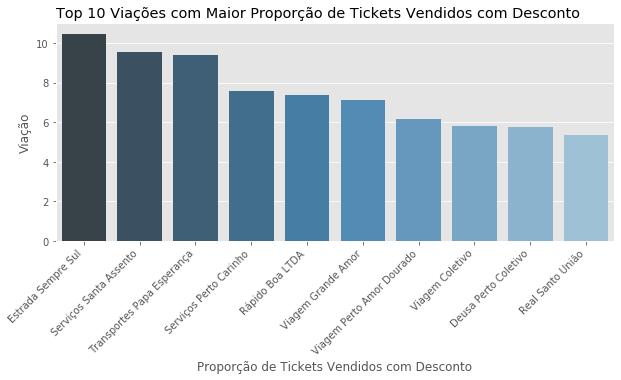

In [0]:
# Gerando um gráfico de barras das empresas com maior percentual de vendas de tickets com desconto:
plt.subplots(figsize=(10, 4))
data = vol_sales_by_company.sort_values('Tickets Com Desconto (%)', ascending=False)[0:10]
sns.barplot(x ='Viação', y='Tickets Com Desconto (%)', data=data, palette='Blues_d')
plt.title('Top 10 Viações com Maior Proporção de Tickets Vendidos com Desconto', loc='left')
plt.xlabel('Proporção de Tickets Vendidos com Desconto')
plt.ylabel('Viação')
plt.xticks(rotation=45, horizontalalignment='right');

Analisando o gráfico, percebemos que a viação com maior percentual de vendas de tickets com desconto foi a Estrada Sempre Sul, com 10,47% dos tickets vendidos com desconto, seguido de Serviços Santa Assento (9.57%) e Transportes Papa Esperança (9,4%).

In [0]:
print('Número de viações que venderam tickets com desconto em 2019:', vol_sales_by_company[vol_sales_by_company['Tickets Com Desconto'] > 0]['Viação'].nunique())

Número de viações que venderam tickets com desconto em 2019: 93


In [0]:
print('Número de viações que venderam mais de 10 tickets com desconto em 2019:', vol_sales_by_company[vol_sales_by_company['Tickets Com Desconto'] > 10]['Viação'].nunique())

Número de viações que venderam mais de 10 tickets com desconto em 2019: 71


Das 93 empresas que venderam tickets com desconto em 2019, apenas 71 delas venderam mais de 10 tickets no período todo.<br>
O mínimo de tickets vendidos com desconto, entre as top 10 , foi de 3058 e o máximo foi de 21230 tickets.

##### Volume de descontos por mês:

In [0]:
# Agrupando os dados por mês e calculando o número de tickets vendidos com desconto:
sales_by_month = pd.DataFrame(sales_by_company.groupby(['Mês'])['Tickets Com Desconto'].sum()).reset_index()
sales_by_month

,Mês,Tickets Com Desconto
0,1,7859.0
1,2,9154.0
2,3,6289.0
3,4,9181.0
4,5,10944.0
5,6,14740.0
6,7,20465.0
7,8,17811.0
8,9,24716.0
9,10,20660.0


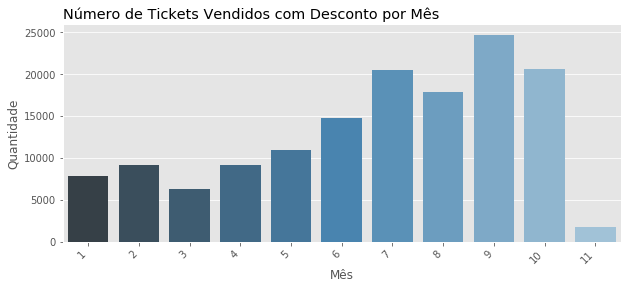

In [0]:
# Gerando um gráfico de barras da venda de tickets com desconto por mês:
plt.subplots(figsize=(10, 4))
sns.barplot(x ='Mês', y='Tickets Com Desconto', data = sales_by_month, palette='Blues_d')
plt.title('Número de Tickets Vendidos com Desconto por Mês', loc='left')
plt.xlabel('Mês')
plt.ylabel('Quantidade')
plt.xticks(rotation=45, horizontalalignment='right');

O mês com maior volume de vendas de tickets com desconto é Setembro, com 20660 vendas.

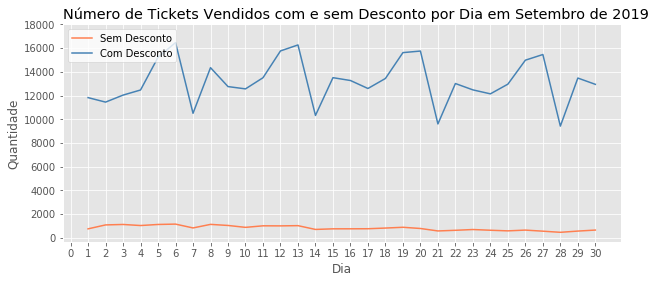

In [0]:
# Analisando as vendas ao longo do mês de Setembro:
data_no_sale = pd.DataFrame(df[(df['month'] == 9) & (df['ticket_sale'] == 1)]['day'].value_counts()).sort_index()
data_sale = pd.DataFrame(df[(df['month'] == 9) & (df['ticket_sale'] == 0)]['day'].value_counts()).sort_index()
plt.subplots(figsize=(10, 4))
plt.plot(data_no_sale, color='coral', label='Sem Desconto')
plt.plot(data_sale, color='steelblue', label = 'Com Desconto')
plt.title('Número de Tickets Vendidos com e sem Desconto por Dia em Setembro de 2019', loc='left')
plt.xlabel('Dia')
plt.ylabel('Quantidade')
plt.xticks(np.arange(0, 31, 1))
plt.yticks(np.arange(0, 20000, 2000))
leg = plt.legend(facecolor='white', edgecolor='silver', loc='upper left');

In [0]:
# Quantas empresas que venderam tickets com desconto em Setembro?
month = df[(df['month'] == 9) & (df['ticket_sale']) == 1]
companies_month = pd.DataFrame(month.groupby('travel_company')['datetime_booking'].count()).sort_values('datetime_booking', ascending=False).reset_index()
companies_month.columns = ['Viação', 'Tickets Com Desconto']
print('Número de empresas que venderam tickets com desconto em Setembro de 2019:', len(companies_month))

Número de empresas que venderam tickets com desconto em Setembro de 2019: 54


In [0]:
# Quantas empresas que venderam mais de 30 tickets com desconto em Setembro? (1 por dia)
month = df[(df['month'] == 9) & (df['ticket_sale']) == 1]
print('Número de empresas que venderam mais de 30 tickets com desconto em Setembro de 2019:', len(companies_month[companies_month['Tickets Com Desconto'] >= 30]))

Número de empresas que venderam mais de 30 tickets com desconto em Setembro de 2019: 36


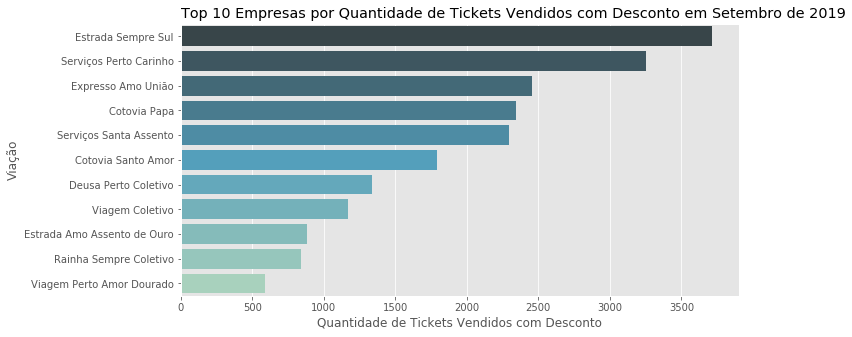

In [0]:
# Gerando um gráfico de barras das empresas que mais venderam tickets com desconto em Setembro:
plt.subplots(figsize=(10,5))
sns.barplot(x ='Tickets Com Desconto', y='Viação', data=companies_month[:11], palette='GnBu_d').set_title("Top 10 Empresas por Quantidade de Tickets Vendidos com Desconto em Setembro de 2019", loc='left')
plt.xlabel('Quantidade de Tickets Vendidos com Desconto')
plt.ylabel('Viação');

O maior volume de vendas de tickets com desconto ocorreu nos meses de Outubro, Setembro e Julho, respectivamente.<br>
Em Setembro, 54 empresas venderam tickets com desconto, mas apenas 36 delas venderam 30 tickets ou mais, o que equivale a pelo menos 1 ticket por dia.<br>
A empresa Estrada Sempre Sul liderou as vendas, com total de aproximadamente 124 tickets com desconto por dia.

#### 4.2 Os descontos mais utilizados (ou seja, os tickets com desconto mais vendidos) têm alguma relação com o fato de serem e-tickets? E tem relação com a disposição do assento entre janela/corredor?

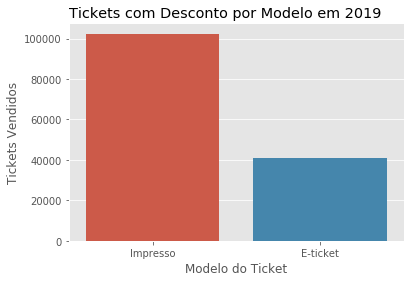

In [0]:
# Gerando um countplot dos modelos dos ticket com desconto:
tickets_on_sale = df[df['ticket_sale']==1]
sns.countplot(data = tickets_on_sale, x='eticket_flag')
plt.ylabel('Tickets Vendidos')
plt.xlabel('Modelo do Ticket')
plt.xticks(np.arange(0,2), ['Impresso', 'E-ticket'])
plt.title('Tickets com Desconto por Modelo em 2019', loc='left');

In [0]:
print('Percentual de tickets com desconto que não são e-tickets (0):', round((len(tickets_on_sale[tickets_on_sale['eticket_flag']==0])/len(tickets_on_sale)*100), 2), '%')
print('Percentual  de tickets com desconto que são e-tickets:', round((len(tickets_on_sale[tickets_on_sale['eticket_flag']==1])/len(tickets_on_sale)*100), 2), '%')

Percentual de tickets com desconto que não são e-tickets (0): 71.32 %
Percentual  de tickets com desconto que são e-tickets: 28.68 %


Analisando os dados das vendas em geral, percebemos que o volume de tickets vendidos que são e-tickets corresponde a 18%.<br>
Porém, quando analisamos os dados dos tickets vendidos com desconto, este percentual sobe para aproximadamente 29%.<br>
Agora, vamos analisar os tickets com desconto mais vendidos isoladamente:

In [0]:
# Os descontos mais utilizados (ou seja, os tickets com desconto mais vendidos) têm alguma relação com o fato de serem e-tickets? 
# Para responder esta pergunta, vamos analisar os tickets com desconto mais vendidos isoladamente:

In [0]:
# Criando uma nova coluna no dataset com o tipo do ticket conforme agrupado por rota, viação, classe de serviço e mês:
dict_type = dict_mode
for i, key in enumerate(dict_type):
    dict_type[key] = i
df['ticket_type'] = list(map(lambda x: dict_type[x], info))
print('Número de tickets-padrão:', len(dict_type))

Número de tickets-padrão: 224187


In [0]:
# Encontrando os tickets com desconto mais vendidos:
best_sellers_sale = pd.DataFrame(df[df['ticket_sale']==1]['ticket_type'].value_counts()).reset_index()
best_sellers_sale.columns = ['Tipo', 'Quantidade de Vendas']
best_sellers_sale['Descrição (Rota, Viação, Classe de Serviço e Mês)'] = best_sellers_sale['Tipo'].map(lambda x: list(dict_type.keys())[x])
best_sellers_sale['Descrição (Rota, Viação, Classe de Serviço e Mês)'] = best_sellers_sale['Descrição (Rota, Viação, Classe de Serviço e Mês)'].map(lambda x: str(x).replace('(', '').replace(')', ''))

In [0]:
# Exibindo os 5 tickets com desconto mais vendidos em 2019:
pd.set_option('display.max_colwidth', -1)
best_sellers_sale.head(5)

,Tipo,Quantidade de Vendas,"Descrição (Rota, Viação, Classe de Serviço e Mês)"
0,101253,1246,"'Igrapiuna | Braco Do Norte', 'Estrada Sempre Sul', 2, 10"
1,123234,1239,"'Igrapiuna | Virmond', 'Serviços Perto Carinho', 2, 9"
2,101367,1239,"'Igrapiuna | Braco Do Norte', 'Serviços Santa Assento', 2, 8"
3,123163,1133,"'Igrapiuna | Virmond', 'Estrada Sempre Sul', 2, 9"
4,101252,1059,"'Igrapiuna | Braco Do Norte', 'Estrada Sempre Sul', 2, 9"


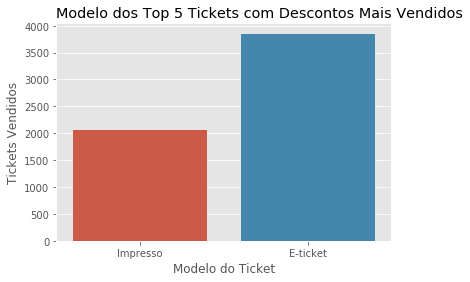

In [0]:
# Analisando o modelo dos top 5 tickets com desconto mais vendidos:
top_5_tickets = df[((df['ticket_type']==101253) | (df['ticket_type']==123234) | (df['ticket_type']==101367) | (df['ticket_type']==123163) | (df['ticket_type']==101252)) & (df['ticket_sale']==1)]
sns.countplot(data = top_5_tickets, x='eticket_flag')
plt.ylabel('Tickets Vendidos')
plt.xlabel('Modelo do Ticket')
plt.xticks(np.arange(0,2), ['Impresso', 'E-ticket'])
plt.title('Modelo dos Top 5 Tickets com Descontos Mais Vendidos', loc='left');

In [0]:
print('Percentual dos top 5 tickets com desconto mais vendidos que não são e-tickets:', round((len(top_5_tickets[top_5_tickets['eticket_flag']==0])/len(top_5_tickets)*100), 2), '%')
print('Percentual dos top 5 tickets com desconto mais vendidos que são e-tickets:', round((len(top_5_tickets[top_5_tickets['eticket_flag']==1])/len(top_5_tickets)*100), 2), '%')

Percentual dos top 5 tickets com desconto mais vendidos que não são e-tickets: 34.91 %
Percentual dos top 5 tickets com desconto mais vendidos que são e-tickets: 65.09 %


Quando analisamos os tickets com desconto mais vendidos, é possível concluir que existe uma forte relação com o fato de serem e-tickets (aproximadamente 65% das vendas).

In [0]:
# Os descontos mais utilizados (ou seja, os tickets com desconto mais vendidos) têm alguma relação com a disposição do assento entre janela/corredor?

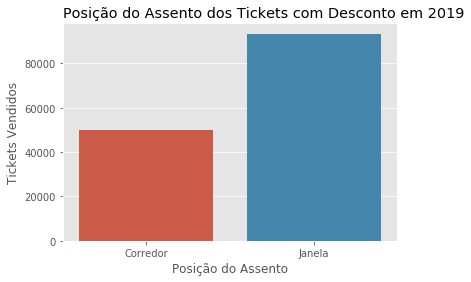

In [0]:
# Gerando um countplot da posição dos assentos dos ticket com desconto:
tickets_on_sale = df[df['ticket_sale']==1]
sns.countplot(data = tickets_on_sale, x='seat_position')
plt.ylabel('Tickets Vendidos')
plt.xlabel('Posição do Assento')
plt.xticks(np.arange(0,2), ['Corredor', 'Janela'])
plt.title('Posição do Assento dos Tickets com Desconto em 2019', loc='left');

In [0]:
print('Percentual de tickets com desconto vendidos que são no corredor (0):', round((len(tickets_on_sale[tickets_on_sale['seat_position']==0])/len(tickets_on_sale)*100), 2), '%')
print('Percentual de tickets com desconto vendidos que são na janela (1):', round((len(tickets_on_sale[tickets_on_sale['seat_position']==1])/len(tickets_on_sale)*100), 2), '%')

Percentual de tickets com desconto vendidos que são no corredor (0): 34.95 %
Percentual de tickets com desconto vendidos que são na janela (1): 65.05 %


Analisando os dados das vendas em geral, percebemos que o volume de tickets vendidos que são no corredor corresponde a 37%.<br>
Quando analisamos os dados dos tickets vendidos com desconto, este percentual cai para aproximadamente 35%.<br>
Agora, vamos analisar os tickets com desconto mais vendidos isoladamente:

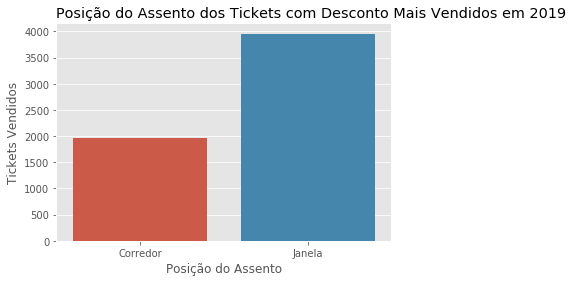

In [0]:
# Analisando o modelo dos top 5 tickets com desconto mais vendidos:
top_5_tickets = df[((df['ticket_type']==101253) | (df['ticket_type']==123234) | (df['ticket_type']==101367) | (df['ticket_type']==123163) | (df['ticket_type']==101252)) & (df['ticket_sale']==1)]
sns.countplot(data = top_5_tickets, x='seat_position')
plt.ylabel('Tickets Vendidos')
plt.xlabel('Posição do Assento')
plt.xticks(np.arange(0,2), ['Corredor', 'Janela'])
plt.title('Posição do Assento dos Tickets com Desconto Mais Vendidos em 2019', loc='left');

In [0]:
print('Percentual de tickets com desconto mais vendidos que são no corredor (0):', round((len(top_5_tickets[top_5_tickets['seat_position']==0])/len(top_5_tickets)*100), 2), '%')
print('Percentual de tickets com desconto mais vendidos que são na janela (1):', round((len(top_5_tickets[top_5_tickets['seat_position']==1])/len(top_5_tickets)*100), 2), '%')

Percentual de tickets com desconto mais vendidos que são no corredor (0): 33.11 %
Percentual de tickets com desconto mais vendidos que são na janela (1): 66.89 %


Analisando os dados dos tickets vendidos com desconto, é possível concluir que não existe relação com a disposição do assento, pois o percentual dos tickets que são no corredor nas vendas em geral (com e sem desconto) é de 37%, e esse percentual cai para 33% quando analisamos somente os tickets com desconto.

#### 4.3 Há alguma relação entre variação de preço na rota e variação de vendas na mesma acima do "normal"?

In [0]:
# Para responder a esta questão, vamos analisar somente as vendas onde há retorno financeiro para a ClickBus:
df['clickbus_profit'] = df['travel_company_commission']*df['unit_ticket_price_success']
df_profit = df[df['clickbus_profit']>0]
print('Número de vendas onde houve retorno financeiro para a ClickBus:', len(df_profit))

Número de vendas onde houve retorno financeiro para a ClickBus: 2444275


In [0]:
# Uma vez agrupados os dados por rota, viação, classe de serviço e mês, vamos analisar quais destas combinações deram maior retorno para a ClickBus, independente de serem com ou sem desconto:
best_sellers = pd.DataFrame(df_profit.groupby('ticket_type')['clickbus_profit'].sum()).reset_index()
best_sellers.columns = ['Tipo', 'Lucro ClickBus (R$)']
best_sellers['Descrição (Rota, Viação, Classe de Serviço e Mês)'] = best_sellers['Tipo'].map(lambda x: list(dict_type.keys())[x])

In [0]:
best_sellers.sort_values('Lucro ClickBus (R$)', ascending=False).head(10)

,Tipo,Lucro ClickBus (R$),"Descrição (Rota, Viação, Classe de Serviço e Mês)"
77895,101366,66691.907100,"(Igrapiuna | Braco Do Norte, Serviços Santa Assento, 2, 7)"
95204,123234,62180.581320,"(Igrapiuna | Virmond, Serviços Perto Carinho, 2, 9)"
77898,101369,59398.725204,"(Igrapiuna | Braco Do Norte, Serviços Santa Assento, 2, 10)"
77896,101367,50435.988876,"(Igrapiuna | Braco Do Norte, Serviços Santa Assento, 2, 8)"
77894,101365,50177.266776,"(Igrapiuna | Braco Do Norte, Serviços Santa Assento, 2, 6)"
77781,101252,46121.450544,"(Igrapiuna | Braco Do Norte, Estrada Sempre Sul, 2, 9)"
77897,101368,43239.357252,"(Igrapiuna | Braco Do Norte, Serviços Santa Assento, 2, 9)"
77841,101312,43164.215640,"(Igrapiuna | Braco Do Norte, Serviços Perto Carinho, 2, 9)"
95202,123232,43142.191560,"(Igrapiuna | Virmond, Serviços Perto Carinho, 2, 7)"
77839,101310,42796.288080,"(Igrapiuna | Braco Do Norte, Serviços Perto Carinho, 2, 7)"


Uma vez que descobrimos as combinações que mais deram retorno a ClickBus, vamos analisar uma à uma para definir se existe relação entre a diminuição do preço e o aumento das vendas.
Para isso, vamos gerar um gráfico onde a linha azul representa a variação das vendas, a linha vermelha, a variação do preço, a linha horizontal laranja, o preço médio do mês, e a linha horizontal verde, o volume médio de vendas do mês.
Em seguida, calculamos, para cada dia, a diferença entre o preço do dia e o preço médio do mês, e a diferença entre as vendas do dia e a venda média do mês, e inserimos estes dados em uma tabela.
Calculamos, então, o coeficiente de correlação entre as colunas 'Variação do Preço em Relação a Média' e 'Variação das Vendas em Relação a Média' para verificar se existe relação entre a diminuição do preço e o aumento das vendas.

##### - Análise Rota 1:

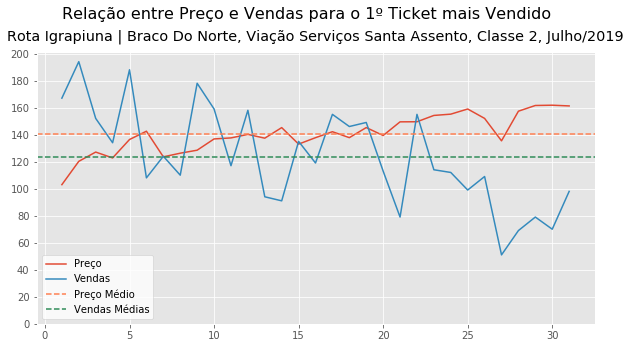

In [0]:
# Exibindo uma time series com a variação do preço e das vendas para o primeiro ticket mais vendido:
plt.figure(figsize=(10,5))
type = 101366
top_1_mean_price = pd.DataFrame(df[df['ticket_type']==type].groupby(['day'])['unit_ticket_price_success'].mean())
top_1_sales = pd.DataFrame(df[df['ticket_type']==type].groupby(['day'])['unit_ticket_price_success'].count())
plt.plot(top_1_mean_price, label = 'Preço')
plt.plot(top_1_sales, label='Vendas')
plt.axhline(y = top_1_mean_price['unit_ticket_price_success'].mean(), color='coral', linestyle='--', label='Preço Médio')
plt.axhline(y = top_1_sales['unit_ticket_price_success'].mean(), color='seagreen', linestyle='--', label='Vendas Médias')
plt.yticks(np.arange(0, 220, 20))
leg = plt.legend(facecolor='white', edgecolor='silver', loc='lower left')
plt.suptitle('Relação entre Preço e Vendas para o 1º Ticket mais Vendido', fontsize=16, y=1.005)
plt.title('Rota Igrapiuna | Braco Do Norte, Viação Serviços Santa Assento, Classe 2, Julho/2019', y=1.02);

In [0]:
# Calculando a diferença entre o preço do dia e o preço médio do mês, e a diferença entre as vendas do dia e a venda média do mês, e inserimos estes dados em uma tabela
type = 101366
df_price = pd.DataFrame(df[df['ticket_type']==type].groupby(['day'])['unit_ticket_price_success'].mean())
df_sales = pd.DataFrame(df[df['ticket_type']==type].groupby(['day'])['unit_ticket_price_success'].count())
df_price.columns = ['Preço']
df_sales.columns = ['Contagem de Vendas']
df_price.insert(1,'Contagem de Vendas', df_sales)
df_price = df_price.reset_index()
df_price.columns = ['Dia', 'Preço', 'Contagem de Vendas']
df_price['Variação das Vendas em Relação a Média'] = df_price['Contagem de Vendas'] - df_price['Contagem de Vendas'].mean()
df_price['Variação do Preço em Relação a Média'] = df_price['Preço'] - df_price['Preço'].mean()
df_price.head()

,Dia,Preço,Contagem de Vendas,Variação das Vendas em Relação a Média,Variação do Preço em Relação a Média
0,1,102.976581,167,43.580645,-37.645162
1,2,120.234387,194,70.580645,-20.387357
2,3,127.092191,152,28.580645,-13.529552
3,4,122.754828,134,10.580645,-17.866915
4,5,136.386803,188,64.580645,-4.234940


Coeficiente de Correlação: -0.5734050626965908


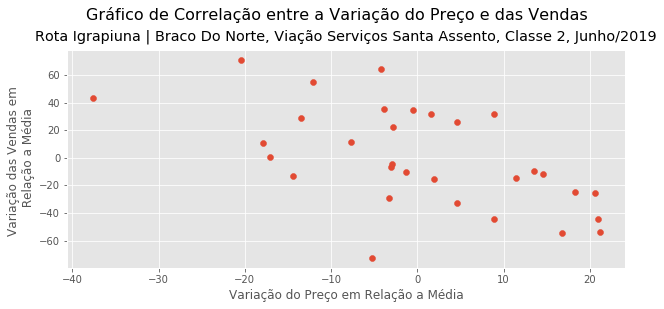

In [0]:
# Gráfico de correlação entre a Variação do Preço e a variação das Vendas:
correlation = df_price['Variação do Preço em Relação a Média'].corr(df_price['Variação das Vendas em Relação a Média'])
print('Coeficiente de Correlação:', correlation)
plt.figure(figsize=(10,4))
plt.scatter(df_price['Variação do Preço em Relação a Média'], df_price['Variação das Vendas em Relação a Média'])
plt.suptitle('Gráfico de Correlação entre a Variação do Preço e das Vendas', fontsize=16, y=1.03)
plt.title('Rota Igrapiuna | Braco Do Norte, Viação Serviços Santa Assento, Classe 2, Junho/2019', y=1.02)
plt.xlabel('Variação do Preço em Relação a Média')
plt.ylabel('Variação das Vendas em \n Relação a Média');

##### - Análise Rota 2:

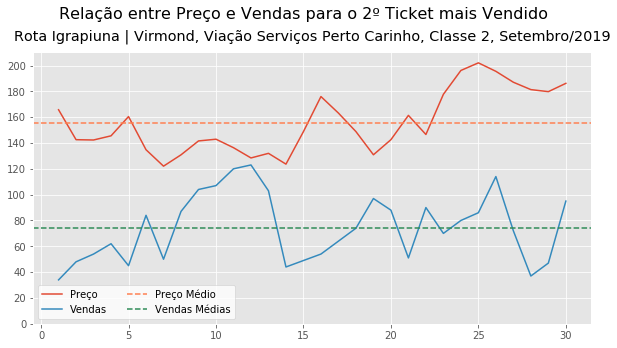

In [0]:
# Exibindo uma time series com a variação do preço e das vendas para o segundo ticket mais vendido:
plt.figure(figsize=(10,5))
type = 123234
top_1_mean_price = pd.DataFrame(df[df['ticket_type']==type].groupby(['day'])['unit_ticket_price_success'].mean())
top_1_sales = pd.DataFrame(df[df['ticket_type']==type].groupby(['day'])['unit_ticket_price_success'].count())
plt.plot(top_1_mean_price, label = 'Preço')
plt.plot(top_1_sales, label='Vendas')
plt.axhline(y = top_1_mean_price['unit_ticket_price_success'].mean(), color='coral', linestyle='--', label='Preço Médio')
plt.axhline(y = top_1_sales['unit_ticket_price_success'].mean(), color='seagreen', linestyle='--', label='Vendas Médias')
plt.yticks(np.arange(0, 220, 20))
leg = plt.legend(facecolor='white', edgecolor='silver', loc='lower left', ncol=2)
plt.suptitle('Relação entre Preço e Vendas para o 2º Ticket mais Vendido', fontsize=16, y=1.005)
plt.title('Rota Igrapiuna | Virmond, Viação Serviços Perto Carinho, Classe 2, Setembro/2019', y=1.02);

In [0]:
# Calculando a diferença entre o preço do dia e o preço médio do mês, e a diferença entre as vendas do dia e a venda média do mês, e inserimos estes dados em uma tabela
type = 123234
df_price = pd.DataFrame(df[df['ticket_type']==type].groupby(['day'])['unit_ticket_price_success'].mean())
df_sales = pd.DataFrame(df[df['ticket_type']==type].groupby(['day'])['unit_ticket_price_success'].count())
df_price.columns = ['Preço']
df_sales.columns = ['Contagem de Vendas']
df_price.insert(1,'Contagem de Vendas', df_sales)
df_price = df_price.reset_index()
df_price.columns = ['Dia', 'Preço', 'Contagem de Vendas']
df_price['Variação das Vendas em Relação a Média'] = df_price['Contagem de Vendas'] - df_price['Contagem de Vendas'].mean()
df_price['Variação do Preço em Relação a Média'] = df_price['Preço'] - df_price['Preço'].mean()
df_price.head()

,Dia,Preço,Contagem de Vendas,Variação das Vendas em Relação a Média,Variação do Preço em Relação a Média
0,1,165.736235,34,-40.433333,9.965271
1,2,142.561792,48,-26.433333,-13.209173
2,3,142.320148,54,-20.433333,-13.450816
3,4,145.550935,62,-12.433333,-10.220029
4,5,160.463911,45,-29.433333,4.692947


Coeficiente de Correlação: -0.13323376688284447


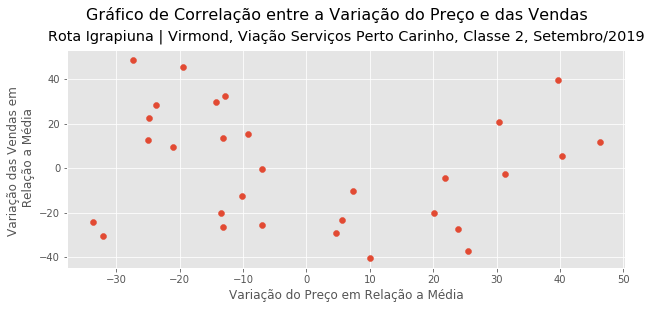

In [0]:
# Gráfico de correlação entre a Variação do Preço e a variação das Vendas:
correlation = df_price['Variação do Preço em Relação a Média'].corr(df_price['Variação das Vendas em Relação a Média'])
print('Coeficiente de Correlação:', correlation)
plt.figure(figsize=(10,4))
plt.scatter(df_price['Variação do Preço em Relação a Média'], df_price['Variação das Vendas em Relação a Média'])
plt.suptitle('Gráfico de Correlação entre a Variação do Preço e das Vendas', fontsize=16, y=1.03)
plt.title('Rota Igrapiuna | Virmond, Viação Serviços Perto Carinho, Classe 2, Setembro/2019', y=1.02)
plt.xlabel('Variação do Preço em Relação a Média')
plt.ylabel('Variação das Vendas em \n Relação a Média');

##### - Análise Rota 3:

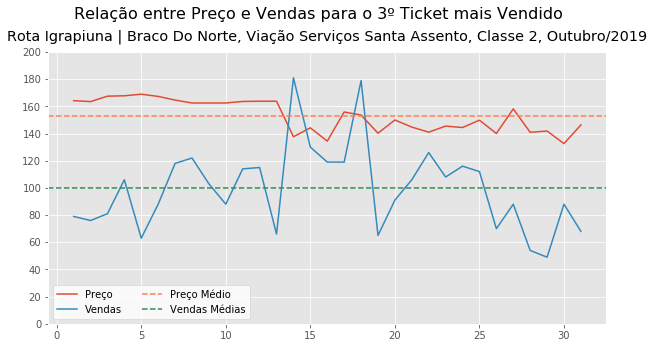

In [0]:
# Exibindo uma time series com a variação do preço e das vendas para o terceiro ticket mais vendido:
plt.figure(figsize=(10,5))
type = 101369
top_1_mean_price = pd.DataFrame(df[df['ticket_type']==type].groupby(['day'])['unit_ticket_price_success'].mean())
top_1_sales = pd.DataFrame(df[df['ticket_type']==type].groupby(['day'])['unit_ticket_price_success'].count())
plt.plot(top_1_mean_price, label = 'Preço')
plt.plot(top_1_sales, label='Vendas')
plt.axhline(y = top_1_mean_price['unit_ticket_price_success'].mean(), color='coral', linestyle='--', label='Preço Médio')
plt.axhline(y = top_1_sales['unit_ticket_price_success'].mean(), color='seagreen', linestyle='--', label='Vendas Médias')
plt.yticks(np.arange(0, 220, 20))
leg = plt.legend(facecolor='white', edgecolor='silver', loc='lower left', ncol=2)
plt.suptitle('Relação entre Preço e Vendas para o 3º Ticket mais Vendido', fontsize=16, y=1.005)
plt.title('Rota Igrapiuna | Braco Do Norte, Viação Serviços Santa Assento, Classe 2, Outubro/2019', y=1.02);

In [0]:
# Calculando a diferença entre o preço do dia e o preço médio do mês, e a diferença entre as vendas do dia e a venda média do mês, e inserimos estes dados em uma tabela
type = 101369
df_price = pd.DataFrame(df[df['ticket_type']==type].groupby(['day'])['unit_ticket_price_success'].mean())
df_sales = pd.DataFrame(df[df['ticket_type']==type].groupby(['day'])['unit_ticket_price_success'].count())
df_price.columns = ['Preço']
df_sales.columns = ['Contagem de Vendas']
df_price.insert(1,'Contagem de Vendas', df_sales)
df_price = df_price.reset_index()
df_price.columns = ['Dia', 'Preço', 'Contagem de Vendas']
df_price['Variação das Vendas em Relação a Média'] = df_price['Contagem de Vendas'] - df_price['Contagem de Vendas'].mean()
df_price['Variação do Preço em Relação a Média'] = df_price['Preço'] - df_price['Preço'].mean()
df_price.head()

,Dia,Preço,Contagem de Vendas,Variação das Vendas em Relação a Média,Variação do Preço em Relação a Média
0,1,164.203329,79,-20.612903,11.175098
1,2,163.506474,76,-23.612903,10.478243
2,3,167.508852,81,-18.612903,14.480621
3,4,167.786340,106,6.387097,14.758109
4,5,168.943667,63,-36.612903,15.915436


Coeficiente de Correlação: -0.10476051102874598


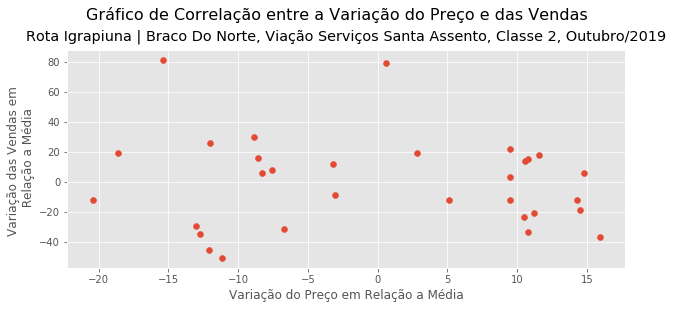

In [0]:
# Gráfico de correlação entre a Variação do Preço e a variação das Vendas:
correlation = df_price['Variação do Preço em Relação a Média'].corr(df_price['Variação das Vendas em Relação a Média'])
print('Coeficiente de Correlação:', correlation)
plt.figure(figsize=(10,4))
plt.scatter(df_price['Variação do Preço em Relação a Média'], df_price['Variação das Vendas em Relação a Média'])
plt.suptitle('Gráfico de Correlação entre a Variação do Preço e das Vendas', fontsize=16, y=1.03)
plt.title('Rota Igrapiuna | Braco Do Norte, Viação Serviços Santa Assento, Classe 2, Outubro/2019', y=1.02)
plt.xlabel('Variação do Preço em Relação a Média')
plt.ylabel('Variação das Vendas em \n Relação a Média');

##### - Análise Rota 4:

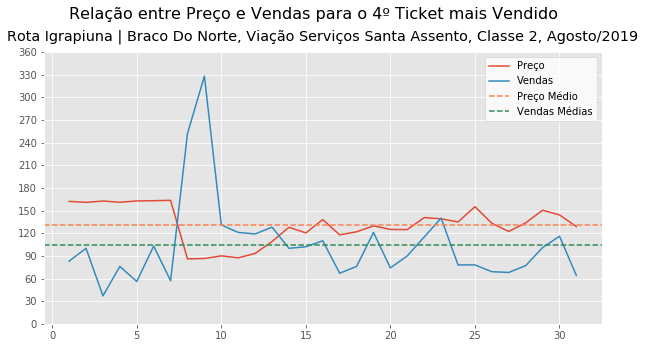

In [0]:
# Exibindo uma time series com a variação do preço e das vendas para o quarto ticket mais vendido:
plt.figure(figsize=(10,5))
type = 101367
top_1_mean_price = pd.DataFrame(df[df['ticket_type']==type].groupby(['day'])['unit_ticket_price_success'].mean())
top_1_sales = pd.DataFrame(df[df['ticket_type']==type].groupby(['day'])['unit_ticket_price_success'].count())
plt.plot(top_1_mean_price, label = 'Preço')
plt.plot(top_1_sales, label='Vendas')
plt.axhline(y = top_1_mean_price['unit_ticket_price_success'].mean(), color='coral', linestyle='--', label='Preço Médio')
plt.axhline(y = top_1_sales['unit_ticket_price_success'].mean(), color='seagreen', linestyle='--', label='Vendas Médias')
plt.yticks(np.arange(0, 380, 30))
leg = plt.legend(facecolor='white', edgecolor='silver', loc='upper right')
plt.suptitle('Relação entre Preço e Vendas para o 4º Ticket mais Vendido', fontsize=16, y=1.005)
plt.title('Rota Igrapiuna | Braco Do Norte, Viação Serviços Santa Assento, Classe 2, Agosto/2019', y=1.02);

In [0]:
# Calculando a diferença entre o preço do dia e o preço médio do mês, e a diferença entre as vendas do dia e a venda média do mês, e inserimos estes dados em uma tabela
type = 101367
df_price = pd.DataFrame(df[df['ticket_type']==type].groupby(['day'])['unit_ticket_price_success'].mean())
df_sales = pd.DataFrame(df[df['ticket_type']==type].groupby(['day'])['unit_ticket_price_success'].count())
df_price.columns = ['Preço']
df_sales.columns = ['Contagem de Vendas']
df_price.insert(1,'Contagem de Vendas', df_sales)
df_price = df_price.reset_index()
df_price.columns = ['Dia', 'Preço', 'Contagem de Vendas']
df_price['Variação das Vendas em Relação a Média'] = df_price['Contagem de Vendas'] - df_price['Contagem de Vendas'].mean()
df_price['Variação do Preço em Relação a Média'] = df_price['Preço'] - df_price['Preço'].mean()
df_price.head()

,Dia,Preço,Contagem de Vendas,Variação das Vendas em Relação a Média,Variação do Preço em Relação a Média
0,1,162.142422,83,-21.419355,30.664836
1,2,160.817800,100,-4.419355,29.340215
2,3,162.616297,37,-67.419355,31.138712
3,4,161.005684,76,-28.419355,29.528099
4,5,162.719143,56,-48.419355,31.241558


Coeficiente de Correlação: -0.6061557905202172


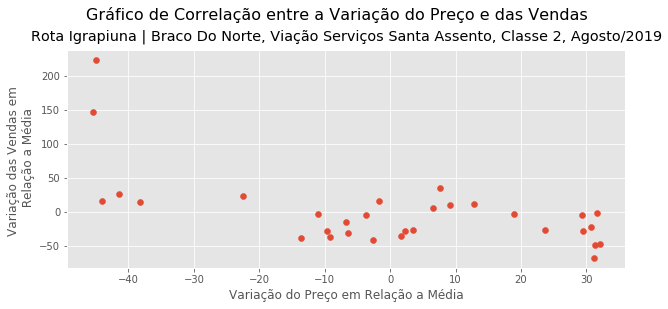

In [0]:
# Gráfico de correlação entre a Variação do Preço e a variação das Vendas:
correlation = df_price['Variação do Preço em Relação a Média'].corr(df_price['Variação das Vendas em Relação a Média'])
print('Coeficiente de Correlação:', correlation)
plt.figure(figsize=(10,4))
plt.scatter(df_price['Variação do Preço em Relação a Média'], df_price['Variação das Vendas em Relação a Média'])
plt.suptitle('Gráfico de Correlação entre a Variação do Preço e das Vendas', fontsize=16, y=1.03)
plt.title('Rota Igrapiuna | Braco Do Norte, Viação Serviços Santa Assento, Classe 2, Agosto/2019', y=1.02)
plt.xlabel('Variação do Preço em Relação a Média')
plt.ylabel('Variação das Vendas em \n Relação a Média');

##### - Análise Rota 5:

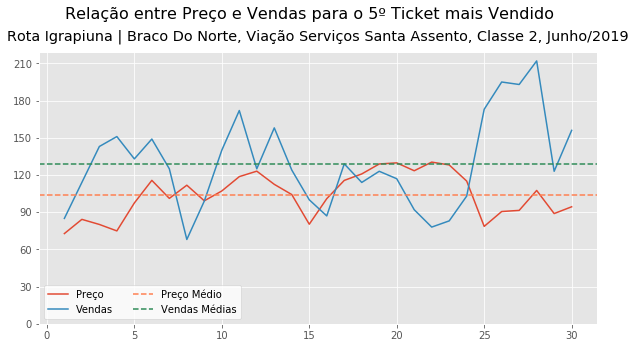

In [0]:
# Exibindo uma time series com a variação do preço e das vendas para o quinto ticket mais vendido:
plt.figure(figsize=(10,5))
type = 101365
top_1_mean_price = pd.DataFrame(df[df['ticket_type']==type].groupby(['day'])['unit_ticket_price_success'].mean())
top_1_sales = pd.DataFrame(df[df['ticket_type']==type].groupby(['day'])['unit_ticket_price_success'].count())
plt.plot(top_1_mean_price, label = 'Preço')
plt.plot(top_1_sales, label='Vendas')
plt.axhline(y = top_1_mean_price['unit_ticket_price_success'].mean(), color='coral', linestyle='--', label='Preço Médio')
plt.axhline(y = top_1_sales['unit_ticket_price_success'].mean(), color='seagreen', linestyle='--', label='Vendas Médias')
plt.yticks(np.arange(0, 220, 30))
leg = plt.legend(facecolor='white', edgecolor='silver', loc='lower left', ncol=2)
plt.suptitle('Relação entre Preço e Vendas para o 5º Ticket mais Vendido', fontsize=16, y=1.005)
plt.title('Rota Igrapiuna | Braco Do Norte, Viação Serviços Santa Assento, Classe 2, Junho/2019', y=1.02);

In [0]:
# Calculando a diferença entre o preço do dia e o preço médio do mês, e a diferença entre as vendas do dia e a venda média do mês, e inserimos estes dados em uma tabela
type = 101365
df_price = pd.DataFrame(df[df['ticket_type']==type].groupby(['day'])['unit_ticket_price_success'].mean())
df_sales = pd.DataFrame(df[df['ticket_type']==type].groupby(['day'])['unit_ticket_price_success'].count())
df_price.columns = ['Preço']
df_sales.columns = ['Contagem de Vendas']
df_price.insert(1,'Contagem de Vendas', df_sales)
df_price = df_price.reset_index()
df_price.columns = ['Dia', 'Preço', 'Contagem de Vendas']
df_price['Variação das Vendas em Relação a Média'] = df_price['Contagem de Vendas'] - df_price['Contagem de Vendas'].mean()
df_price['Variação do Preço em Relação a Média'] = df_price['Preço'] - df_price['Preço'].mean()
df_price.head()

,Dia,Preço,Contagem de Vendas,Variação das Vendas em Relação a Média,Variação do Preço em Relação a Média
0,1,72.767729,85,-43.8,-31.490606
1,2,84.223123,114,-14.8,-20.035212
2,3,80.124636,143,14.2,-24.133699
3,4,74.915987,151,22.2,-29.342348
4,5,97.446338,133,4.2,-6.811997


Coeficiente de Correlação: -0.24692149581472322


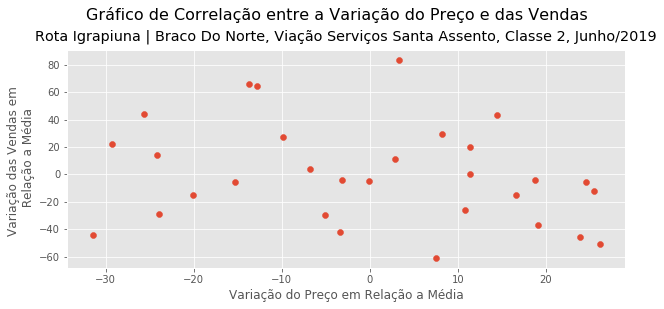

In [0]:
# Gráfico de correlação entre a Variação do Preço e a variação das Vendas:
correlation = df_price['Variação do Preço em Relação a Média'].corr(df_price['Variação das Vendas em Relação a Média'])
print('Coeficiente de Correlação:', correlation)
plt.figure(figsize=(10,4))
plt.scatter(df_price['Variação do Preço em Relação a Média'], df_price['Variação das Vendas em Relação a Média'])
plt.suptitle('Gráfico de Correlação entre a Variação do Preço e das Vendas', fontsize=16, y=1.03)
plt.title('Rota Igrapiuna | Braco Do Norte, Viação Serviços Santa Assento, Classe 2, Junho/2019', y=1.02)
plt.xlabel('Variação do Preço em Relação a Média')
plt.ylabel('Variação das Vendas em \n Relação a Média');

##### - Análise Rota 6:

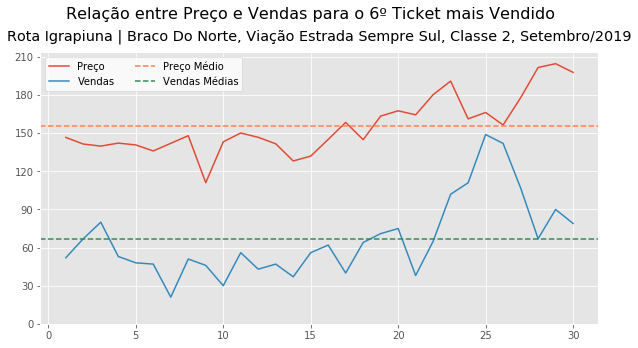

In [0]:
# Exibindo uma time series com a variação do preço e das vendas para o sexto ticket mais vendido:
plt.figure(figsize=(10,5))
type = 101252
top_1_mean_price = pd.DataFrame(df[df['ticket_type']==type].groupby(['day'])['unit_ticket_price_success'].mean())
top_1_sales = pd.DataFrame(df[df['ticket_type']==type].groupby(['day'])['unit_ticket_price_success'].count())
plt.plot(top_1_mean_price, label = 'Preço')
plt.plot(top_1_sales, label='Vendas')
plt.axhline(y = top_1_mean_price['unit_ticket_price_success'].mean(), color='coral', linestyle='--', label='Preço Médio')
plt.axhline(y = top_1_sales['unit_ticket_price_success'].mean(), color='seagreen', linestyle='--', label='Vendas Médias')
plt.yticks(np.arange(0, 220, 30))
leg = plt.legend(facecolor='white', edgecolor='silver', loc='upper left', ncol=2)
plt.suptitle('Relação entre Preço e Vendas para o 6º Ticket mais Vendido', fontsize=16, y=1.005)
plt.title('Rota Igrapiuna | Braco Do Norte, Viação Estrada Sempre Sul, Classe 2, Setembro/2019', y=1.02);

In [0]:
# Calculando a diferença entre o preço do dia e o preço médio do mês, e a diferença entre as vendas do dia e a venda média do mês, e inserimos estes dados em uma tabela
type = 101252
df_price = pd.DataFrame(df[df['ticket_type']==type].groupby(['day'])['unit_ticket_price_success'].mean())
df_sales = pd.DataFrame(df[df['ticket_type']==type].groupby(['day'])['unit_ticket_price_success'].count())
df_price.columns = ['Preço']
df_sales.columns = ['Contagem de Vendas']
df_price.insert(1,'Contagem de Vendas', df_sales)
df_price = df_price.reset_index()
df_price.columns = ['Dia', 'Preço', 'Contagem de Vendas']
df_price['Variação das Vendas em Relação a Média'] = df_price['Contagem de Vendas'] - df_price['Contagem de Vendas'].mean()
df_price['Variação do Preço em Relação a Média'] = df_price['Preço'] - df_price['Preço'].mean()
df_price.head()

,Dia,Preço,Contagem de Vendas,Variação das Vendas em Relação a Média,Variação do Preço em Relação a Média
0,1,146.734250,52,-14.533333,-9.042942
1,2,141.514896,67,0.466667,-14.262297
2,3,139.895600,80,13.466667,-15.881592
3,4,142.248698,53,-13.533333,-13.528494
4,5,140.818438,48,-18.533333,-14.958755


Coeficiente de Correlação: 0.46924227891384407


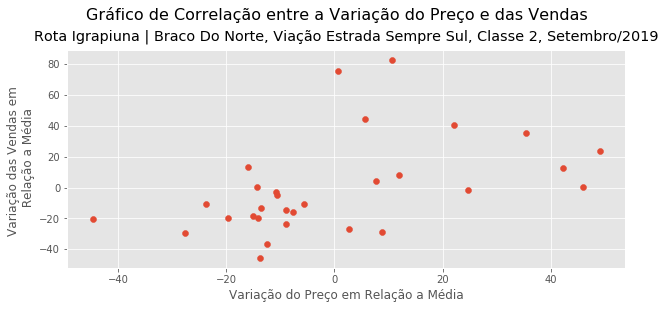

In [0]:
# Gráfico de correlação entre a Variação do Preço e a variação das Vendas:
correlation = df_price['Variação do Preço em Relação a Média'].corr(df_price['Variação das Vendas em Relação a Média'])
print('Coeficiente de Correlação:', correlation)
plt.figure(figsize=(10,4))
plt.scatter(df_price['Variação do Preço em Relação a Média'], df_price['Variação das Vendas em Relação a Média'])
plt.suptitle('Gráfico de Correlação entre a Variação do Preço e das Vendas', fontsize=16, y=1.03)
plt.title('Rota Igrapiuna | Braco Do Norte, Viação Estrada Sempre Sul, Classe 2, Setembro/2019', y=1.02)
plt.xlabel('Variação do Preço em Relação a Média')
plt.ylabel('Variação das Vendas em \n Relação a Média');

##### - Análise Rota 7:

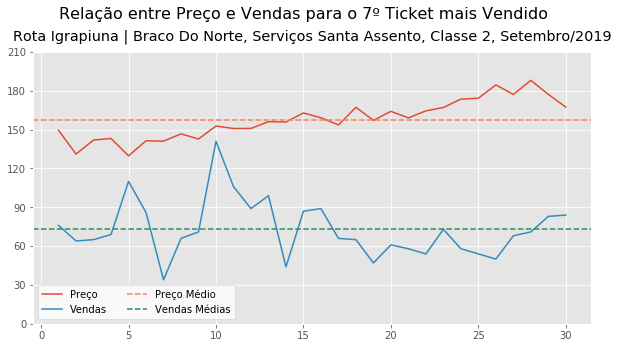

In [0]:
# Exibindo uma time series com a variação do preço e das vendas para o sétimo ticket mais vendido:
plt.figure(figsize=(10,5))
type = 101368
top_1_mean_price = pd.DataFrame(df[df['ticket_type']==type].groupby(['day'])['unit_ticket_price_success'].mean())
top_1_sales = pd.DataFrame(df[df['ticket_type']==type].groupby(['day'])['unit_ticket_price_success'].count())
plt.plot(top_1_mean_price, label = 'Preço')
plt.plot(top_1_sales, label='Vendas')
plt.axhline(y = top_1_mean_price['unit_ticket_price_success'].mean(), color='coral', linestyle='--', label='Preço Médio')
plt.axhline(y = top_1_sales['unit_ticket_price_success'].mean(), color='seagreen', linestyle='--', label='Vendas Médias')
plt.yticks(np.arange(0, 220, 30))
leg = plt.legend(facecolor='white', edgecolor='silver', loc='lower left', ncol=2)
plt.suptitle('Relação entre Preço e Vendas para o 7º Ticket mais Vendido', fontsize=16, y=1.005)
plt.title('Rota Igrapiuna | Braco Do Norte, Serviços Santa Assento, Classe 2, Setembro/2019', y=1.02);

In [0]:
# Calculando a diferença entre o preço do dia e o preço médio do mês, e a diferença entre as vendas do dia e a venda média do mês, e inserimos estes dados em uma tabela
type = 101368
df_price = pd.DataFrame(df[df['ticket_type']==type].groupby(['day'])['unit_ticket_price_success'].mean())
df_sales = pd.DataFrame(df[df['ticket_type']==type].groupby(['day'])['unit_ticket_price_success'].count())
df_price.columns = ['Preço']
df_sales.columns = ['Contagem de Vendas']
df_price.insert(1,'Contagem de Vendas', df_sales)
df_price = df_price.reset_index()
df_price.columns = ['Dia', 'Preço', 'Contagem de Vendas']
df_price['Variação das Vendas em Relação a Média'] = df_price['Contagem de Vendas'] - df_price['Contagem de Vendas'].mean()
df_price['Variação do Preço em Relação a Média'] = df_price['Preço'] - df_price['Preço'].mean()
df_price.head()

,Dia,Preço,Contagem de Vendas,Variação das Vendas em Relação a Média,Variação do Preço em Relação a Média
0,1,149.488882,76,3.066667,-8.239482
1,2,131.108453,64,-8.933333,-26.619910
2,3,141.990200,65,-7.933333,-15.738163
3,4,143.178420,69,-3.933333,-14.549943
4,5,129.750164,110,37.066667,-27.978200


Coeficiente de Correlação: -0.20474477955636824


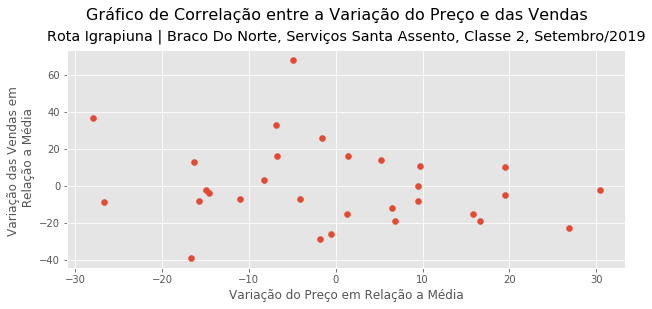

In [0]:
# Gráfico de correlação entre a Variação do Preço e a variação das Vendas:
correlation = df_price['Variação do Preço em Relação a Média'].corr(df_price['Variação das Vendas em Relação a Média'])
print('Coeficiente de Correlação:', correlation)
plt.figure(figsize=(10,4))
plt.scatter(df_price['Variação do Preço em Relação a Média'], df_price['Variação das Vendas em Relação a Média'])
plt.suptitle('Gráfico de Correlação entre a Variação do Preço e das Vendas', fontsize=16, y=1.03)
plt.title('Rota Igrapiuna | Braco Do Norte, Serviços Santa Assento, Classe 2, Setembro/2019', y=1.02)
plt.xlabel('Variação do Preço em Relação a Média')
plt.ylabel('Variação das Vendas em \n Relação a Média');

##### - Análise Rota 8:

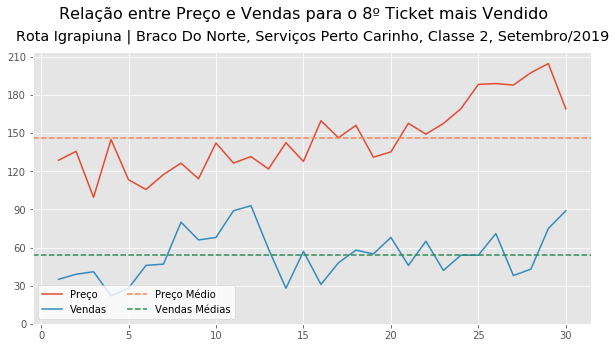

In [0]:
# Exibindo uma time series com a variação do preço e das vendas para o oitavo ticket mais vendido:
plt.figure(figsize=(10,5))
type = 101312
top_1_mean_price = pd.DataFrame(df[df['ticket_type']==type].groupby(['day'])['unit_ticket_price_success'].mean())
top_1_sales = pd.DataFrame(df[df['ticket_type']==type].groupby(['day'])['unit_ticket_price_success'].count())
plt.plot(top_1_mean_price, label = 'Preço')
plt.plot(top_1_sales, label='Vendas')
plt.axhline(y = top_1_mean_price['unit_ticket_price_success'].mean(), color='coral', linestyle='--', label='Preço Médio')
plt.axhline(y = top_1_sales['unit_ticket_price_success'].mean(), color='seagreen', linestyle='--', label='Vendas Médias')
plt.yticks(np.arange(0, 220, 30))
leg = plt.legend(facecolor='white', edgecolor='silver', loc='lower left', ncol=2)
plt.suptitle('Relação entre Preço e Vendas para o 8º Ticket mais Vendido', fontsize=16, y=1.005)
plt.title('Rota Igrapiuna | Braco Do Norte, Serviços Perto Carinho, Classe 2, Setembro/2019', y=1.02);

In [0]:
# Calculando a diferença entre o preço do dia e o preço médio do mês, e a diferença entre as vendas do dia e a venda média do mês, e inserimos estes dados em uma tabela
type = 101312
df_price = pd.DataFrame(df[df['ticket_type']==type].groupby(['day'])['unit_ticket_price_success'].mean())
df_sales = pd.DataFrame(df[df['ticket_type']==type].groupby(['day'])['unit_ticket_price_success'].count())
df_price.columns = ['Preço']
df_sales.columns = ['Contagem de Vendas']
df_price.insert(1,'Contagem de Vendas', df_sales)
df_price = df_price.reset_index()
df_price.columns = ['Dia', 'Preço', 'Contagem de Vendas']
df_price['Variação das Vendas em Relação a Média'] = df_price['Contagem de Vendas'] - df_price['Contagem de Vendas'].mean()
df_price['Variação do Preço em Relação a Média'] = df_price['Preço'] - df_price['Preço'].mean()
df_price.head()

,Dia,Preço,Contagem de Vendas,Variação das Vendas em Relação a Média,Variação do Preço em Relação a Média
0,1,128.790257,35,-19.5,-17.197994
1,2,135.743333,39,-15.5,-10.244918
2,3,99.574610,41,-13.5,-46.413642
3,4,145.082955,22,-32.5,-0.905297
4,5,113.402250,28,-26.5,-32.586001


Coeficiente de Correlação: 0.07231424104069395


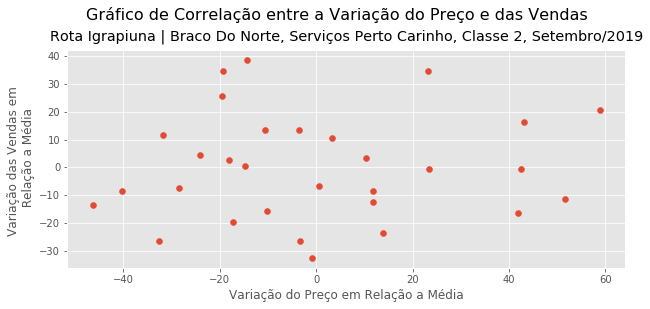

In [0]:
# Gráfico de correlação entre a Variação do Preço e a variação das Vendas:
correlation = df_price['Variação do Preço em Relação a Média'].corr(df_price['Variação das Vendas em Relação a Média'])
print('Coeficiente de Correlação:', correlation)
plt.figure(figsize=(10,4))
plt.scatter(df_price['Variação do Preço em Relação a Média'], df_price['Variação das Vendas em Relação a Média'])
plt.suptitle('Gráfico de Correlação entre a Variação do Preço e das Vendas', fontsize=16, y=1.03)
plt.title('Rota Igrapiuna | Braco Do Norte, Serviços Perto Carinho, Classe 2, Setembro/2019', y=1.02)
plt.xlabel('Variação do Preço em Relação a Média')
plt.ylabel('Variação das Vendas em \n Relação a Média');

##### - Análise Rota 9:

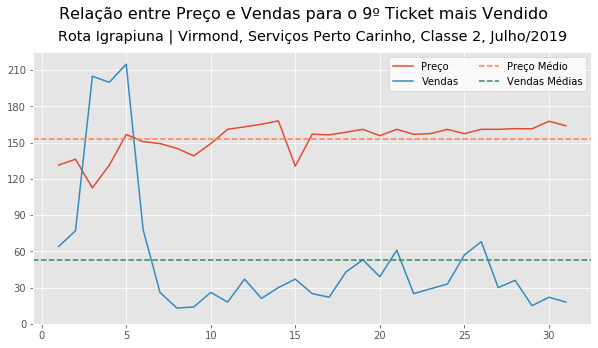

In [0]:
# Exibindo uma time series com a variação do preço e das vendas para o nono ticket mais vendido:
plt.figure(figsize=(10,5))
type = 123232
top_1_mean_price = pd.DataFrame(df[df['ticket_type']==type].groupby(['day'])['unit_ticket_price_success'].mean())
top_1_sales = pd.DataFrame(df[df['ticket_type']==type].groupby(['day'])['unit_ticket_price_success'].count())
plt.plot(top_1_mean_price, label = 'Preço')
plt.plot(top_1_sales, label='Vendas')
plt.axhline(y = top_1_mean_price['unit_ticket_price_success'].mean(), color='coral', linestyle='--', label='Preço Médio')
plt.axhline(y = top_1_sales['unit_ticket_price_success'].mean(), color='seagreen', linestyle='--', label='Vendas Médias')
plt.yticks(np.arange(0, 220, 30))
leg = plt.legend(facecolor='white', edgecolor='silver', loc='upper right', ncol=2)
plt.suptitle('Relação entre Preço e Vendas para o 9º Ticket mais Vendido', fontsize=16, y=1.005)
plt.title('Rota Igrapiuna | Virmond, Serviços Perto Carinho, Classe 2, Julho/2019', y=1.02);

In [0]:
# Calculando a diferença entre o preço do dia e o preço médio do mês, e a diferença entre as vendas do dia e a venda média do mês, e inserimos estes dados em uma tabela
type = 123232
df_price = pd.DataFrame(df[df['ticket_type']==type].groupby(['day'])['unit_ticket_price_success'].mean())
df_sales = pd.DataFrame(df[df['ticket_type']==type].groupby(['day'])['unit_ticket_price_success'].count())
df_price.columns = ['Preço']
df_sales.columns = ['Contagem de Vendas']
df_price.insert(1,'Contagem de Vendas', df_sales)
df_price = df_price.reset_index()
df_price.columns = ['Dia', 'Preço', 'Contagem de Vendas']
df_price['Variação das Vendas em Relação a Média'] = df_price['Contagem de Vendas'] - df_price['Contagem de Vendas'].mean()
df_price['Variação do Preço em Relação a Média'] = df_price['Preço'] - df_price['Preço'].mean()
df_price.head()

,Dia,Preço,Contagem de Vendas,Variação das Vendas em Relação a Média,Variação do Preço em Relação a Média
0,1,131.468188,64,11.193548,-21.769218
1,2,136.294364,77,24.193548,-16.943042
2,3,112.562054,205,152.193548,-40.675352
3,4,131.335165,200,147.193548,-21.902240
4,5,156.772865,215,162.193548,3.535460


Coeficiente de Correlação: -0.5237021577321286


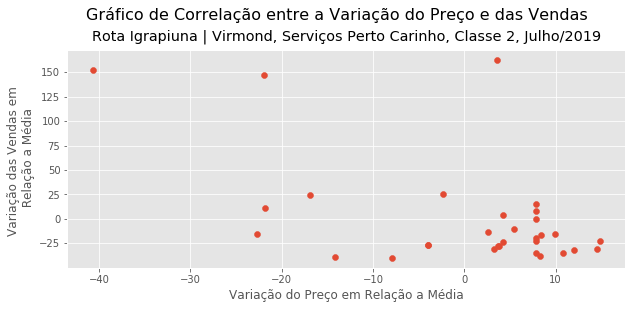

In [0]:
# Gráfico de correlação entre a Variação do Preço e a variação das Vendas:
correlation = df_price['Variação do Preço em Relação a Média'].corr(df_price['Variação das Vendas em Relação a Média'])
print('Coeficiente de Correlação:', correlation)
plt.figure(figsize=(10,4))
plt.scatter(df_price['Variação do Preço em Relação a Média'], df_price['Variação das Vendas em Relação a Média'])
plt.suptitle('Gráfico de Correlação entre a Variação do Preço e das Vendas', fontsize=16, y=1.03)
plt.title('Rota Igrapiuna | Virmond, Serviços Perto Carinho, Classe 2, Julho/2019', y=1.02)
plt.xlabel('Variação do Preço em Relação a Média')
plt.ylabel('Variação das Vendas em \n Relação a Média');

##### - Análise Rota 10:

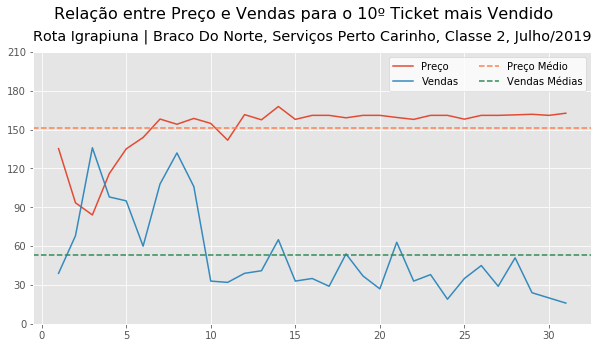

In [0]:
# Exibindo uma time series com a variação do preço e das vendas para o décimo ticket mais vendido:
plt.figure(figsize=(10,5))
type = 101310
top_1_mean_price = pd.DataFrame(df[df['ticket_type']==type].groupby(['day'])['unit_ticket_price_success'].mean())
top_1_sales = pd.DataFrame(df[df['ticket_type']==type].groupby(['day'])['unit_ticket_price_success'].count())
plt.plot(top_1_mean_price, label = 'Preço')
plt.plot(top_1_sales, label='Vendas')
plt.axhline(y = top_1_mean_price['unit_ticket_price_success'].mean(), color='coral', linestyle='--', label='Preço Médio')
plt.axhline(y = top_1_sales['unit_ticket_price_success'].mean(), color='seagreen', linestyle='--', label='Vendas Médias')
plt.yticks(np.arange(0, 220, 30))
leg = plt.legend(facecolor='white', edgecolor='silver', loc='upper right', ncol=2)
plt.suptitle('Relação entre Preço e Vendas para o 10º Ticket mais Vendido', fontsize=16, y=1.005)
plt.title('Rota Igrapiuna | Braco Do Norte, Serviços Perto Carinho, Classe 2, Julho/2019', y=1.02);

In [0]:
# Calculando a diferença entre o preço do dia e o preço médio do mês, e a diferença entre as vendas do dia e a venda média do mês, e inserimos estes dados em uma tabela
type = 101310
df_price = pd.DataFrame(df[df['ticket_type']==type].groupby(['day'])['unit_ticket_price_success'].mean())
df_sales = pd.DataFrame(df[df['ticket_type']==type].groupby(['day'])['unit_ticket_price_success'].count())
df_price.columns = ['Preço']
df_sales.columns = ['Contagem de Vendas']
df_price.insert(1,'Contagem de Vendas', df_sales)
df_price = df_price.reset_index()
df_price.columns = ['Dia', 'Preço', 'Contagem de Vendas']
df_price['Variação das Vendas em Relação a Média'] = df_price['Contagem de Vendas'] - df_price['Contagem de Vendas'].mean()
df_price['Variação do Preço em Relação a Média'] = df_price['Preço'] - df_price['Preço'].mean()
df_price.head()

,Dia,Preço,Contagem de Vendas,Variação das Vendas em Relação a Média,Variação do Preço em Relação a Média
0,1,135.380000,39,-13.903226,-15.942465
1,2,93.506706,68,15.096774,-57.815759
2,3,84.088684,136,83.096774,-67.233781
3,4,116.058694,98,45.096774,-35.263771
4,5,135.146358,95,42.096774,-16.176107


Coeficiente de Correlação: -0.529032108596729


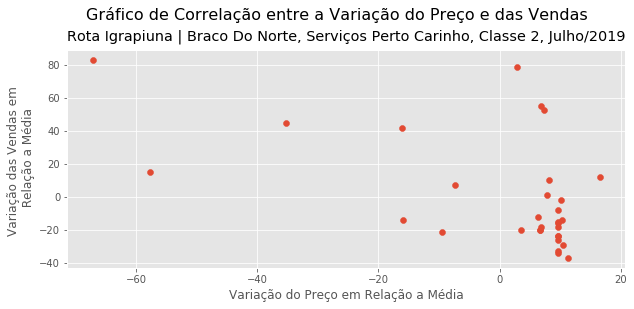

In [0]:
# Gráfico de correlação entre a Variação do Preço e a variação das Vendas:
correlation = df_price['Variação do Preço em Relação a Média'].corr(df_price['Variação das Vendas em Relação a Média'])
print('Coeficiente de Correlação:', correlation)
plt.figure(figsize=(10,4))
plt.scatter(df_price['Variação do Preço em Relação a Média'], df_price['Variação das Vendas em Relação a Média'])
plt.suptitle('Gráfico de Correlação entre a Variação do Preço e das Vendas', fontsize=16, y=1.03)
plt.title('Rota Igrapiuna | Braco Do Norte, Serviços Perto Carinho, Classe 2, Julho/2019', y=1.02)
plt.xlabel('Variação do Preço em Relação a Média')
plt.ylabel('Variação das Vendas em \n Relação a Média');

Analisando os coeficientes de correlação entre a variação do preço e a variação das vendas das rotas mais lucrativas (-0.573, -0.133, -0.104, -0.606, -0.246, 0.469, -0.204, 0.072, -0.523 e -0.529) foi possível perceber que como a maior parte dos coeficientes de correlação são negativos, isso mostra que existe uma relação inversamente proporcional entre o preço e as vendas. Ou seja, quando o preço diminui, as vendas tendem a aumentar, e vice-versa. Porém, esta relação se torna mais expressiva (coeficiente de correlação mais próximos de -1) para algumas combinações de rotas/viações/meses/classes do que para outras. As variações acima do "normal" entre preço e vendas, ou seja, aquelas onde os valores estão mais distantes das linhas médias, são perceptíveis nos gráficos, e quanto maior esta variação, mais próximo de -1 tende a ser o coeficiente de correlação.

#### 4.4 Pensando no crescimento de vendas através do desconto, para quais viações você pediria descontos no final de ano e em quais rotas?

In [0]:
# Ordenando os tickets conforme o coeficiente de correlação:
coef_corr = [-0.573, -0.133, -0.104, -0.606, -0.246, 0.469, -0.204, 0.072, -0.523, -0.529]
best_sellers_coef = best_sellers.sort_values('Lucro ClickBus (R$)', ascending=False).head(10).drop(['Lucro ClickBus (R$)', 'Tipo'], axis=1)
best_sellers_coef['Correlação'] = coef_corr
best_sellers_coef = best_sellers_coef.sort_values('Correlação')

In [0]:
best_sellers_coef

,"Descrição (Rota, Viação, Classe de Serviço e Mês)",Correlação
77896,"(Igrapiuna | Braco Do Norte, Serviços Santa Assento, 2, 8)",-0.606
77895,"(Igrapiuna | Braco Do Norte, Serviços Santa Assento, 2, 7)",-0.573
77839,"(Igrapiuna | Braco Do Norte, Serviços Perto Carinho, 2, 7)",-0.529
95202,"(Igrapiuna | Virmond, Serviços Perto Carinho, 2, 7)",-0.523
77894,"(Igrapiuna | Braco Do Norte, Serviços Santa Assento, 2, 6)",-0.246
77897,"(Igrapiuna | Braco Do Norte, Serviços Santa Assento, 2, 9)",-0.204
95204,"(Igrapiuna | Virmond, Serviços Perto Carinho, 2, 9)",-0.133
77898,"(Igrapiuna | Braco Do Norte, Serviços Santa Assento, 2, 10)",-0.104
77841,"(Igrapiuna | Braco Do Norte, Serviços Perto Carinho, 2, 9)",0.072
77781,"(Igrapiuna | Braco Do Norte, Estrada Sempre Sul, 2, 9)",0.469


As rotas para as quais indicamos descontos são:
  

1.   Igrapiuna | Braco Do Norte (viação Serviços Santa Assento);
2.   Igrapiuna | Braco Do Norte (viação Serviços Perto Carrinho);
3.   Igrapiuna | Virmond (viação Serviços Perto Carrinho) e;
4.   Igrapiuna | Braco Do Norte (Estrada Sempre Sul).

Visto que foram as combinações que apresentaram coeficiente de correlação mais próximos de -1, logo, existe correlação entre a diminuição do preço e o aumento das vendas, e vice-versa.